# NLP and Reddit Subcommunities - EDA and Cleaning
---

In this notebook, we will be exploring and visualizing the data pulled via PRAW API on our two Reddit communities. We will look into variables such as post length, word count, number of upvotes, number of comments, and will utilize CountVectorizer to see the top words within and between communities. We will manipulate variables and do any associated cleaning as necessary. 

For more information on the data pull and initial data cleaning, see the [initial notebook](./code/01_PRAW_Data_Acquisition_Cleaning.ipynb) of this analysis. For model-building and testing, see the [third notebook](./code/03_Model_Building_Testing.ipynb) iterating across various models to find which ones are best at predicting the origin of a post.

For more information on the background, a summary of methods, and findings, please see the associated [README](./README.md) for this analysis.

### Contents:
- [I. Pre-Processing and Descriptive Statistics](#I.-Pre-Processing-and-Descriptive-Statistics)
- [II. Associations / Pairplots](#II.-Associations-/-Pairplots)
    - [Outlier Exploration](#Outlier-Exploration)
- [III. Correlations and Distributions](#III.-Correlations-and-Distributions)
- [IV. User-Level Exploration](#IV.-User-Level-Exploration)
- [V. Text / Language Processing and Exploration](#V.-Text-/-Language-Processing-and-Exploration)
    - [Top Unigrams, Bigrams, Trigrams by Activity](#Top-Unigrams,-Bigrams,-Trigrams-by-Activity)
    - [Most Common Words by Top 25% of Upvoted Posts](#Most-Common-Words-by-Top-25%-of-Upvoted-Posts)
    - [Most Common Words by Top 25% Most Commented Posts](#Most-Common-Words-by-Top-25%-Most-Commented-Posts)
    - [Most Common Words Comparison](#Most-Common-Words-Comparison)

In [ ]:
import warnings
warnings.filterwarnings('ignore') # Notebook was run with warnings enabled and significant ones have been addressed, remaining warnings are insignificant and have been suppressed

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400

In [2]:
import os
os.getcwd()

'C:\\Users\\farah\\Documents\\General Assembly DSI\\DSI-508\\Projects\\project-3\\code'

In [3]:
df1 = pd.read_csv('../data/Clean/snow_ski.csv')

In [4]:
df = df1.drop(columns=['selftext', 'title'])

In [5]:
# Distribution of Communities
df.subreddit.value_counts()

skiing               2889
snowboardingnoobs    2748
Name: subreddit, dtype: int64

In [6]:
df.subreddit.value_counts(normalize=True)

skiing               0.512507
snowboardingnoobs    0.487493
Name: subreddit, dtype: float64

In [7]:
df.dtypes

created_utc     float64
author           object
score             int64
upvote_ratio    float64
num_comments      int64
subreddit        object
text             object
lem_text         object
stem_text        object
dtype: object

In [8]:
df.shape

(5637, 9)

In [9]:
df.head().append(df.tail())

C:\Users\farah\AppData\Local\Temp\ipykernel_25972\3069207714.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.head().append(df.tail())


,created_utc,author,score,upvote_ratio,num_comments,subreddit,text,lem_text,stem_text
0,1.686844e+09,bas1cred,26,0.91,19,snowboardingnoobs,my first board. ready for the upcoming season!!,my first board ready for the upcoming season,my first board readi for the upcom season
1,1.686786e+09,Pooffios,3,1.00,12,snowboardingnoobs,"outer side foot pain hi all, i was hoping to get some recommendations on boots, currently i have the burton photons however the outer side of my foot is always killing me after a few runs. does this mean the boot is too narrow? if so what are some wider boots because i do not think i have “wide” feet",outer side foot pain hi all i wa hoping to get some recommendation on boot currently i have the burton photon however the outer side of my foot is always killing me after a few run doe this mean the boot is too narrow if so what are some wider boot because i do not think i have wide foot,outer side foot pain hi all i wa hope to get some recommend on boot current i have the burton photon howev the outer side of my foot is alway kill me after a few run doe thi mean the boot is too narrow if so what are some wider boot becaus i do not think i have wide feet
2,1.686781e+09,trips69420,2,0.75,15,snowboardingnoobs,"first board? looking to probably grab this as my first board, working on a budget and it’s a great deal since i live in the desert. any thoughts/comments from anyone who knows a little more on it? i’m pretty new to the sport, been on the slopes a total of probably 5-6 times",first board looking to probably grab this a my first board working on a budget and it s a great deal since i live in the desert any thought comment from anyone who know a little more on it i m pretty new to the sport been on the slope a total of probably 5 6 time,first board look to probabl grab thi as my first board work on a budget and it s a great deal sinc i live in the desert ani thought comment from anyon who know a littl more on it i m pretti new to the sport been on the slope a total of probabl 5 6 time
3,1.686779e+09,twinbee,11,0.87,0,snowboardingnoobs,"i did a front-side 180 today! more than one in fact. okay, i didn't jump when doing it, let alone hit a kicker (ramp), but still...this has to be the easiest trick you can do on a snowboard. i think it looked like this, but where the spin was maybe slower: https://www.youtube.com/watch?v=bp6pbkujjtm&t=92s (just 4 seconds of video, i've linked the exact video starting point).i'm getting to grip...",i did a front side 180 today more than one in fact okay i didn t jump when doing it let alone hit a kicker ramp but still this ha to be the easiest trick you can do on a snowboard i think it looked like this but where the spin wa maybe slower http www youtube com watch v bp6pbkujjtm t 92s just 4 second of video i ve linked the exact video starting point i m getting to grip with switch and can ...,i did a front side 180 today more than one in fact okay i didn t jump when do it let alon hit a kicker ramp but still thi ha to be the easiest trick you can do on a snowboard i think it look like thi but where the spin wa mayb slower http www youtub com watch v bp6pbkujjtm t 92 just 4 second of video i ve link the exact video start point i m get to grip with switch and can swing myself round 1...
4,1.686767e+09,Madden_Stephen,2,0.67,24,snowboardingnoobs,"step-on boot recommendation? i’ve done a decent bit of research on the different offerings from burton & dc, and would love to try them on prior to purchasing, but unfortunately that is not an option currently. with that i will be purchasing and then returning if the fit isn’t right. definitely would like to stick with the boa system. - i’ve ridden a medium flex boot the past two years prior t...",step on boot recommendation i ve done a decent bit of research on the different offering from burton dc and would love to try them on prior to purchasing but unfortunately that is not an option currently with that i will be purchasing and then retu

## I. Pre-Processing and Descriptive Statistics

In [10]:
df['post_length'] = df['text'].apply(len)

In [11]:
def word_count(text):
    return len([i for i in text.split()])

df['post_word_count'] = df['text'].apply(word_count)

In [12]:
df.head()

,created_utc,author,score,upvote_ratio,num_comments,subreddit,text,lem_text,stem_text,post_length,post_word_count
0,1.686844e+09,bas1cred,26,0.91,19,snowboardingnoobs,my first board. ready for the upcoming season!!,my first board ready for the upcoming season,my first board readi for the upcom season,48,8
1,1.686786e+09,Pooffios,3,1.00,12,snowboardingnoobs,"outer side foot pain hi all, i was hoping to get some recommendations on boots, currently i have the burton photons however the outer side of my foot is always killing me after a few runs. does this mean the boot is too narrow? if so what are some wider boots because i do not think i have “wide” feet",outer side foot pain hi all i wa hoping to get some recommendation on boot currently i have the burton photon however the outer side of my foot is always killing me after a few run doe this mean the boot is too narrow if so what are some wider boot because i do not think i have wide foot,outer side foot pain hi all i wa hope to get some recommend on boot current i have the burton photon howev the outer side of my foot is alway kill me after a few run doe thi mean the boot is too narrow if so what are some wider boot becaus i do not think i have wide feet,301,60
2,1.686781e+09,trips69420,2,0.75,15,snowboardingnoobs,"first board? looking to probably grab this as my first board, working on a budget and it’s a great deal since i live in the desert. any thoughts/comments from anyone who knows a little more on it? i’m pretty new to the sport, been on the slopes a total of probably 5-6 times",first board looking to probably grab this a my first board working on a budget and it s a great deal since i live in the desert any thought comment from anyone who know a little more on it i m pretty new to the sport been on the slope a total of probably 5 6 time,first board look to probabl grab thi as my first board work on a budget and it s a great deal sinc i live in the desert ani thought comment from anyon who know a littl more on it i m pretti new to the sport been on the slope a total of probabl 5 6 time,274,53
3,1.686779e+09,twinbee,11,0.87,0,snowboardingnoobs,"i did a front-side 180 today! more than one in fact. okay, i didn't jump when doing it, let alone hit a kicker (ramp), but still...this has to be the easiest trick you can do on a snowboard. i think it looked like this, but where the spin was maybe slower: https://www.youtube.com/watch?v=bp6pbkujjtm&t=92s (just 4 seconds of video, i've linked the exact video starting point).i'm getting to grip...",i did a front side 180 today more than one in fact okay i didn t jump when doing it let alone hit a kicker ramp but still this ha to be the easiest trick you can do on a snowboard i think it looked like this but where the spin wa maybe slower http www youtube com watch v bp6pbkujjtm t 92s just 4 second of video i ve linked the exact video starting point i m getting to grip with switch and can ...,i did a front side 180 today more than one in fact okay i didn t jump when do it let alon hit a kicker ramp but still thi ha to be the easiest trick you can do on a snowboard i think it look like thi but where the spin wa mayb slower http www youtub com watch v bp6pbkujjtm t 92 just 4 second of video i ve link the exact video start point i m get to grip with switch and can swing myself round 1...,1565,289
4,1.686767e+09,Madden_Stephen,2,0.67,24,snowboardingnoobs,"step-on boot recommendation? i’ve done a decent bit of research on the different offerings from burton & dc, and would love to try them on prior to purchasing, but unfortunately that is not an option currently. with that i will be purchasing and then returning if the fit isn’t right. definitely would like to stick with the boa system. - i’ve ridden a medium flex boot the past two years prior t...",step on boot recommendation i ve done a decent bit of research on the different offering from burton dc and would love to try them on prior to purchasing but unfortunately that is not an optio

In [13]:
# OVERALL Descriptive Statistics
df.describe()

,created_utc,score,upvote_ratio,num_comments,post_length,post_word_count
count,5.637000e+03,5637.000000,5637.000000,5637.000000,5637.000000,5637.000000
mean,1.628017e+09,423.954054,0.802221,37.010821,249.244101,44.962037
std,7.329224e+07,914.105988,0.215497,68.697424,426.972962,75.689403
min,1.319562e+09,0.000000,0.130000,0.000000,2.000000,1.000000
25%,1.605551e+09,1.000000,0.580000,5.000000,42.000000,8.000000
50%,1.651620e+09,10.000000,0.930000,14.000000,85.000000,16.000000
75%,1.679955e+09,146.000000,0.990000,40.000000,281.000000,52.000000
max,1.686878e+09,10099.000000,1.000000,1380.000000,6983.000000,1115.000000


In [14]:
# SNOWBOARDING Descriptive Statistics
snow = df[df.subreddit == "snowboardingnoobs"]
snow.describe()

,created_utc,score,upvote_ratio,num_comments,post_length,post_word_count
count,2.748000e+03,2748.000000,2748.000000,2748.000000,2748.000000,2748.000000
mean,1.643983e+09,35.370451,0.830247,15.371179,337.859170,61.008006
std,4.343021e+07,65.216575,0.199653,16.675137,471.163895,83.915770
min,1.477281e+09,0.000000,0.130000,0.000000,7.000000,1.000000
25%,1.612729e+09,1.000000,0.670000,5.000000,61.000000,11.000000
50%,1.669162e+09,5.000000,0.940000,10.000000,161.000000,29.000000
75%,1.678555e+09,46.000000,1.000000,20.000000,444.250000,81.000000
max,1.686844e+09,867.000000,1.000000,165.000000,6298.000000,1115.000000


In [15]:
# SKIING Descriptive Statistics
ski = df[df.subreddit == "skiing"]
ski.describe()

,created_utc,score,upvote_ratio,num_comments,post_length,post_word_count
count,2.889000e+03,2889.000000,2889.000000,2889.000000,2889.000000,2889.000000
mean,1.612830e+09,793.572516,0.775562,57.594323,164.953963,29.699204
std,9.064068e+07,1160.295229,0.226392,89.866623,360.607861,63.276970
min,1.319562e+09,0.000000,0.130000,0.000000,2.000000,1.000000
25%,1.580520e+09,1.000000,0.530000,6.000000,34.000000,6.000000
50%,1.645632e+09,31.000000,0.910000,27.000000,59.000000,10.000000
75%,1.682006e+09,1571.000000,0.980000,77.000000,126.000000,23.000000
max,1.686878e+09,10099.000000,1.000000,1380.000000,6983.000000,1105.000000


##### <span style='color:blue'>Many Reddit statistics appear to be highly right skewed for all three tables (Overall, Snowboarders, Skiers). For example, the mean score per post is 793.6 for skiers, but the median is 31.0. Snowboarders were less skewed, but still quite skewed (mean: 35.4, median: 5.0)</span>

## II. Associations / Pairplots

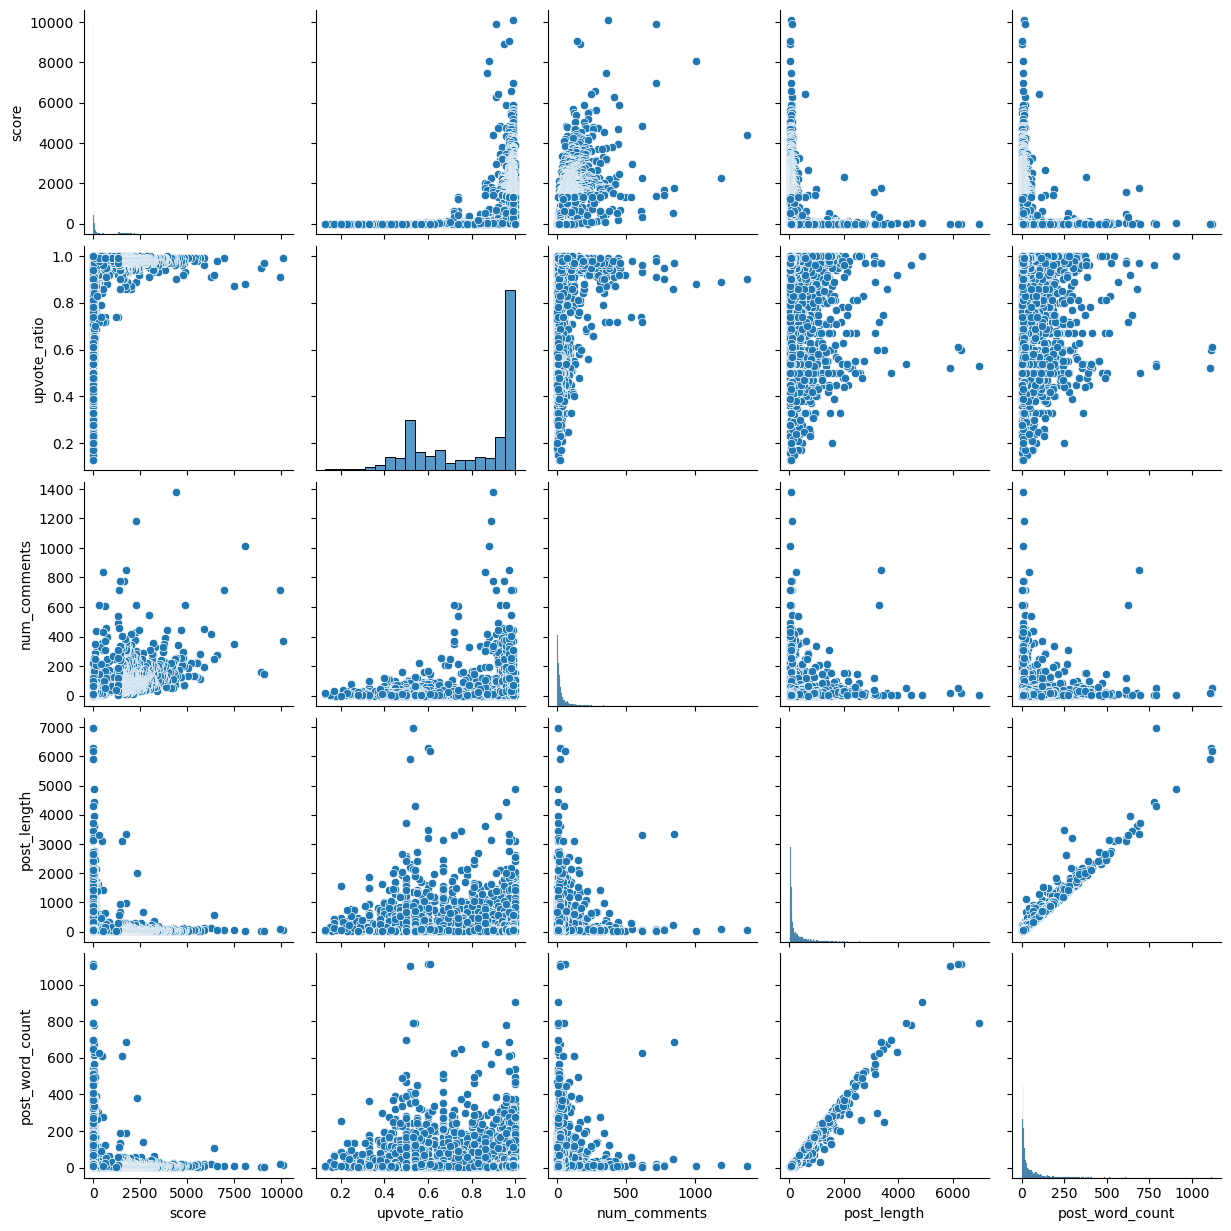

In [16]:
# Initial Look at Correlations - Using default parameters to see density of concentrated points (offwhite clusters)
sns.pairplot(df, x_vars = ['score', 'upvote_ratio', 'num_comments', 'post_length', 'post_word_count'], y_vars = ['score', 'upvote_ratio', 'num_comments', 'post_length', 'post_word_count']);

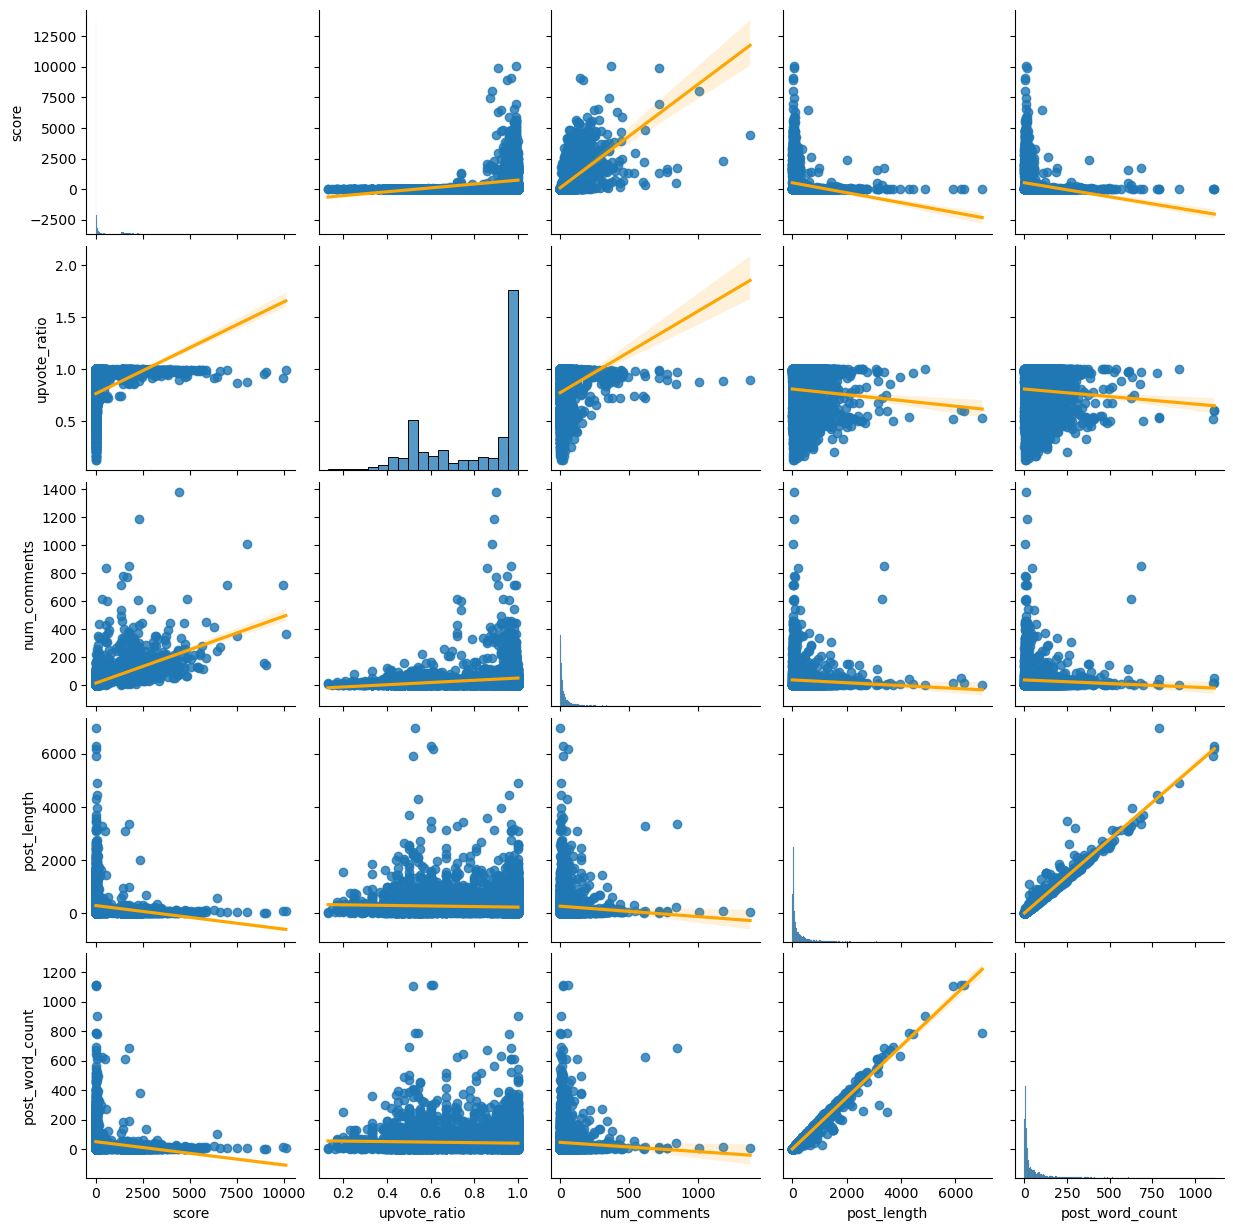

In [17]:
# With Regline
sns.pairplot(df, x_vars = ['score', 'upvote_ratio', 'num_comments', 'post_length', 'post_word_count'], y_vars = ['score', 'upvote_ratio', 'num_comments', 'post_length', 'post_word_count'], kind='reg', plot_kws={'line_kws':{'color':'orange'}});

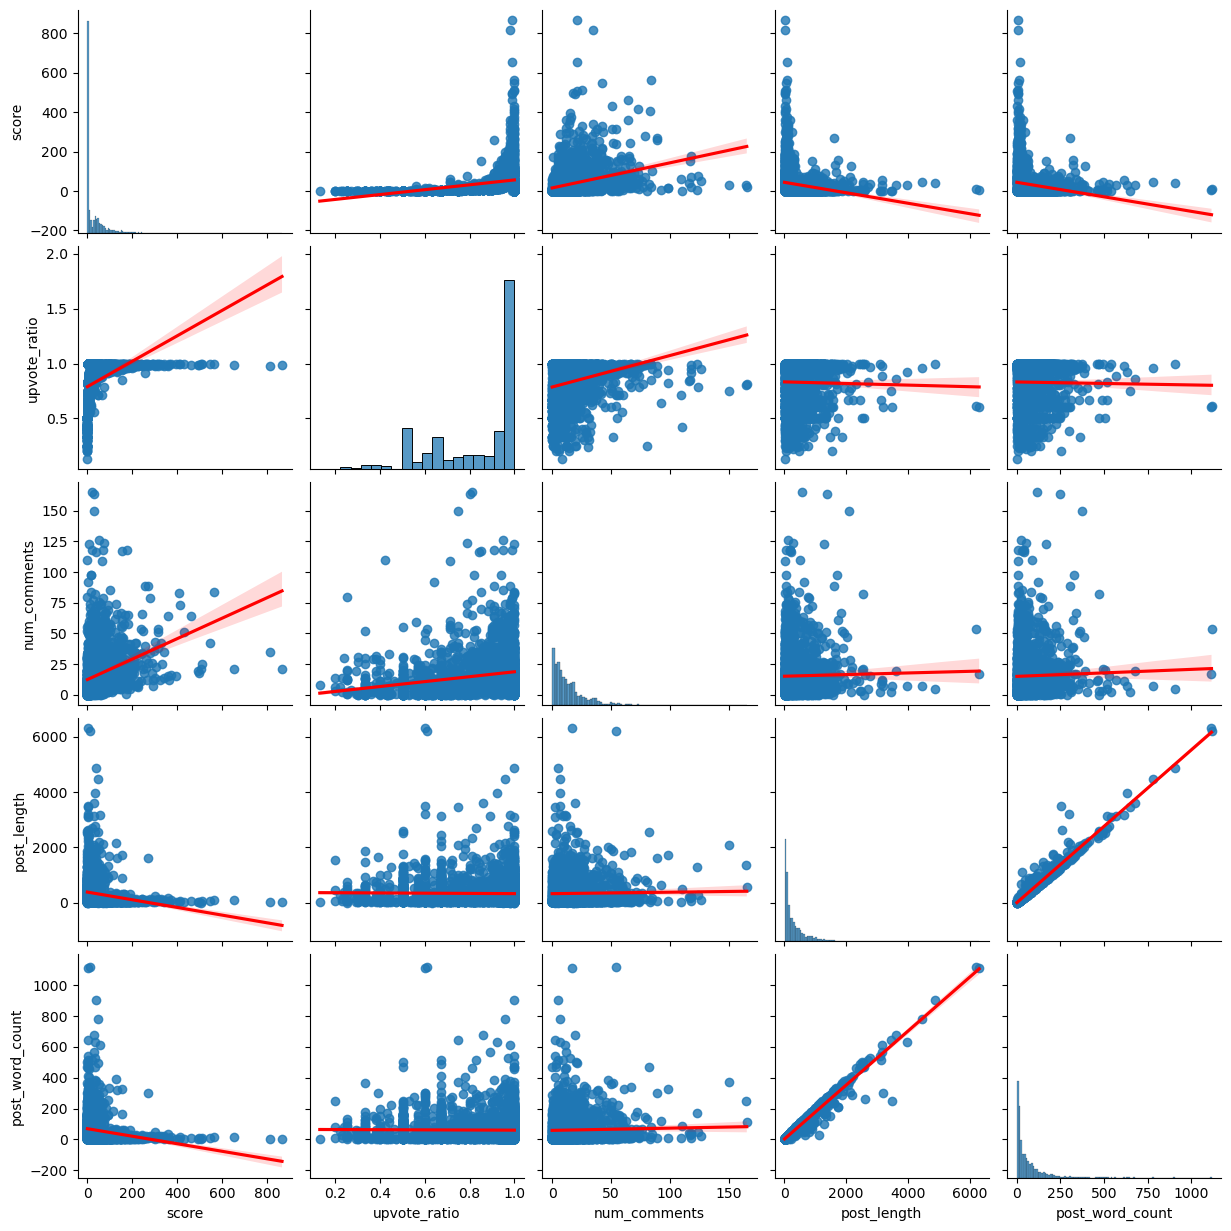

In [18]:
# Snowboarding Only - With Regline
sns.pairplot(snow, x_vars = ['score', 'upvote_ratio', 'num_comments', 'post_length', 'post_word_count'], y_vars = ['score', 'upvote_ratio', 'num_comments', 'post_length', 'post_word_count'], kind='reg', plot_kws={'line_kws':{'color':'red'}});

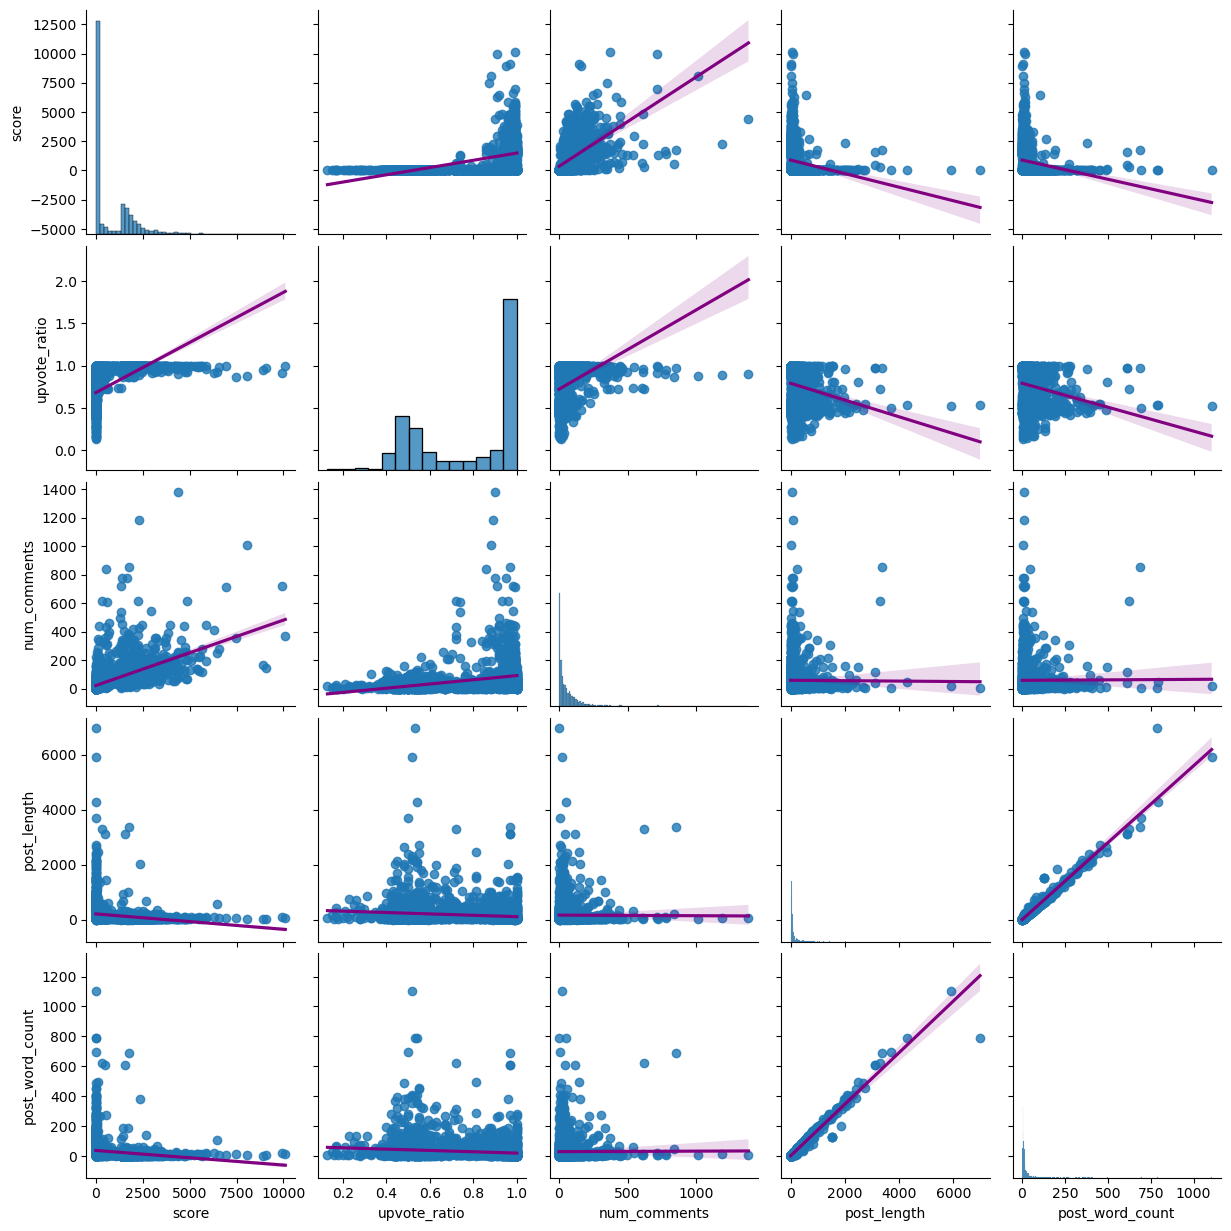

In [19]:
# Skiing Only - With Regline
sns.pairplot(ski, x_vars = ['score', 'upvote_ratio', 'num_comments', 'post_length', 'post_word_count'], y_vars = ['score', 'upvote_ratio', 'num_comments', 'post_length', 'post_word_count'], kind='reg', plot_kws={'line_kws':{'color':'purple'}});

##### <span style='color:blue'>There are no strong relationships between any of the continuous variables, except, unsurprisingly, post length and post word count. The histograms show very high right skewedness with some extreme outliers. There is an upward trajectory between the post's score and number of comments it gets within the Overall (both Snowboarders and Skiers) category, which appears to be being driven by Skiers; generally, the more popular the post, the more comments it will garner. </span>
    
##### <span style='color:blue'>Higher scores are associated with higher upvote ratios, though not always - there appear to be many posts with a score of 0 which have 100% upvote ratios. It is possible these are more recent posts, or posts which are informative, stories, announcements, or otherwise which do not create need for discussion or comment beyond giving an upvote.</span>

### Outlier Exploration

In [20]:
# Explore Anomylous Data Point
df[df.post_length > 6500]

# Appears to be an ad / promo

,created_utc,author,score,upvote_ratio,num_comments,subreddit,text,lem_text,stem_text,post_length,post_word_count
5556,1.536167e+09,tetonpassboarder,1,0.53,2,skiing,"ski.com is looking for the ideal candidate to experience more than a dozen resorts around the world on a single trip during january and february 2019 ski.com to hire mountain enthusiast to travel the world for ski.com’s epic dream job· in partnership with the epic pass, ski.com is looking for the ideal candidate to experience more than a dozen resorts around the world on a single trip during j...",ski com is looking for the ideal candidate to experience more than a dozen resort around the world on a single trip during january and february 2019 ski com to hire mountain enthusiast to travel the world for ski com s epic dream job in partnership with the epic pas ski com is looking for the ideal candidate to experience more than a dozen resort around the world on a single trip during januar...,ski com is look for the ideal candid to experi more than a dozen resort around the world on a singl trip dure januari and februari 2019 ski com to hire mountain enthusiast to travel the world for ski com s epic dream job in partnership with the epic pass ski com is look for the ideal candid to experi more than a dozen resort around the world on a singl trip dure januari and februari 2019 the i...,6983,789


In [21]:
df[df['text'].str.lower().str.contains('ski.com')]

,created_utc,author,score,upvote_ratio,num_comments,subreddit,text,lem_text,stem_text,post_length,post_word_count
2799,1.686410e+09,HikeBikeSkiCo,0,0.28,11,skiing,"i saw the incredible video of the skier falling 1000ft off maroon bells and wrote a blog post about it. (video included) if you found this story as interesting as i do there's his video off the fall, which he also detailed in a podcast episode. i broke both down in the below blog post for those that don't want to listen to the entire podcast. (video and podcast links included)https://hike-bike...",i saw the incredible video of the skier falling 1000ft off maroon bell and wrote a blog post about it video included if you found this story a interesting a i do there s his video off the fall which he also detailed in a podcast episode i broke both down in the below blog post for those that don t want to listen to the entire podcast video and podcast link included http hike bike ski com terri...,i saw the incred video of the skier fall 1000ft off maroon bell and wrote a blog post about it video includ if you found thi stori as interest as i do there s hi video off the fall which he also detail in a podcast episod i broke both down in the below blog post for those that don t want to listen to the entir podcast video and podcast link includ http hike bike ski com terrifi skier plummet 1...,468,71
3496,1.681837e+09,MathematicianFine228,0,0.38,15,skiing,"iso queer skiers! hey you! do you identify as lgbtq+? i'm looking for queer skiers/riders for a film project i'm working on. i'm interested to hear about your experiences in the greater ski community in regards to your gender identity or sexual orientation. as a queer person myself, i've noticed the ski community has a ""don't ask don't tell"" vibe about queerness.",iso queer skier hey you do you identify a lgbtq i m looking for queer skier rider for a film project i m working on i m interested to hear about your experience in the greater ski community in regard to your gender identity or sexual orientation a a queer person myself i ve noticed the ski community ha a don t ask don t tell vibe about queerness,iso queer skier hey you do you identifi as lgbtq i m look for queer skier rider for a film project i m work on i m interest to hear about your experi in the greater ski commun in regard to your gender ident or sexual orient as a queer person myself i ve notic the ski commun ha a don t ask don t tell vibe about queer,365,62
4696,1.468097e+09,ojsca,0,0.47,44,skiing,"advice on skis to buy for next season i'm planning on doing a ski season in the alps (probably switzerland or italy), hopefully get a job as a ski guide and thought i should invest in my first pair of skis (have always rented before, and rental is included in job offer, but thought it would be worth it). i'm a proficient skier on and off piste, but not a racer or anything. i would probably wan...",advice on ski to buy for next season i m planning on doing a ski season in the alp probably switzerland or italy hopefully get a job a a ski guide and thought i should invest in my first pair of ski have always rented before and rental is included in job offer but thought it would be worth it i m a proficient skier on and off piste but not a racer or anything i would probably want some twin ti...,advic on ski to buy for next season i m plan on do a ski season in the alp probabl switzerland or itali hope get a job as a ski guid and thought i should invest in my first pair of ski have alway rent befor and rental is includ in job offer but thought it would be worth it i m a profici skier on and off pist but not a racer or anyth i would probabl want some twin tip for park etc what would yo...,1211,225
5392,1.647610e+09,Freeski802,0,0.50,13,skiing,"how do people get sponsored? i've seen so many people get sponsored who aren't ""considered"" pros and they get sponsored by awesome ski company's. how does a good skier but not like crazy good get sponsored?",how do people get sp

In [22]:
# Only the outlier data point seems to be an advertisement, the rest seem fine - exclude the one post - do not overwrite current dataset in Clean folder so that we do not have to rerun notebook 1
df = df[df.post_length < 6500]
snow = snow[snow.post_length < 6500]
ski = ski[ski.post_length < 6500]

df.to_csv('../data/Clean/snow_ski2.csv', index=False)

In [23]:
df.shape

(5636, 11)

In [ ]:
# Explore other three datapoints (snowboarding observations) to see if they are anomylous / need to be deleted
df[(df.post_word_count < 400) & ((df.post_length > 2500) & (df.post_length < 4000))]

##### <span style='color:blue'>A few data points which were visually inspected to be anomalous were briefly explored. One of the posts appeared to be a ski.com advertisement and was removed.</span>

## III. Correlations and Distributions

C:\Users\farah\AppData\Local\Temp\ipykernel_25972\2060145566.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()
C:\Users\farah\AppData\Local\Temp\ipykernel_25972\2060145566.py:26: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = snow.corr()
C:\Users\farah\AppData\Local\Temp\ipykernel_25972\2060145566.py:46: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = ski.corr()


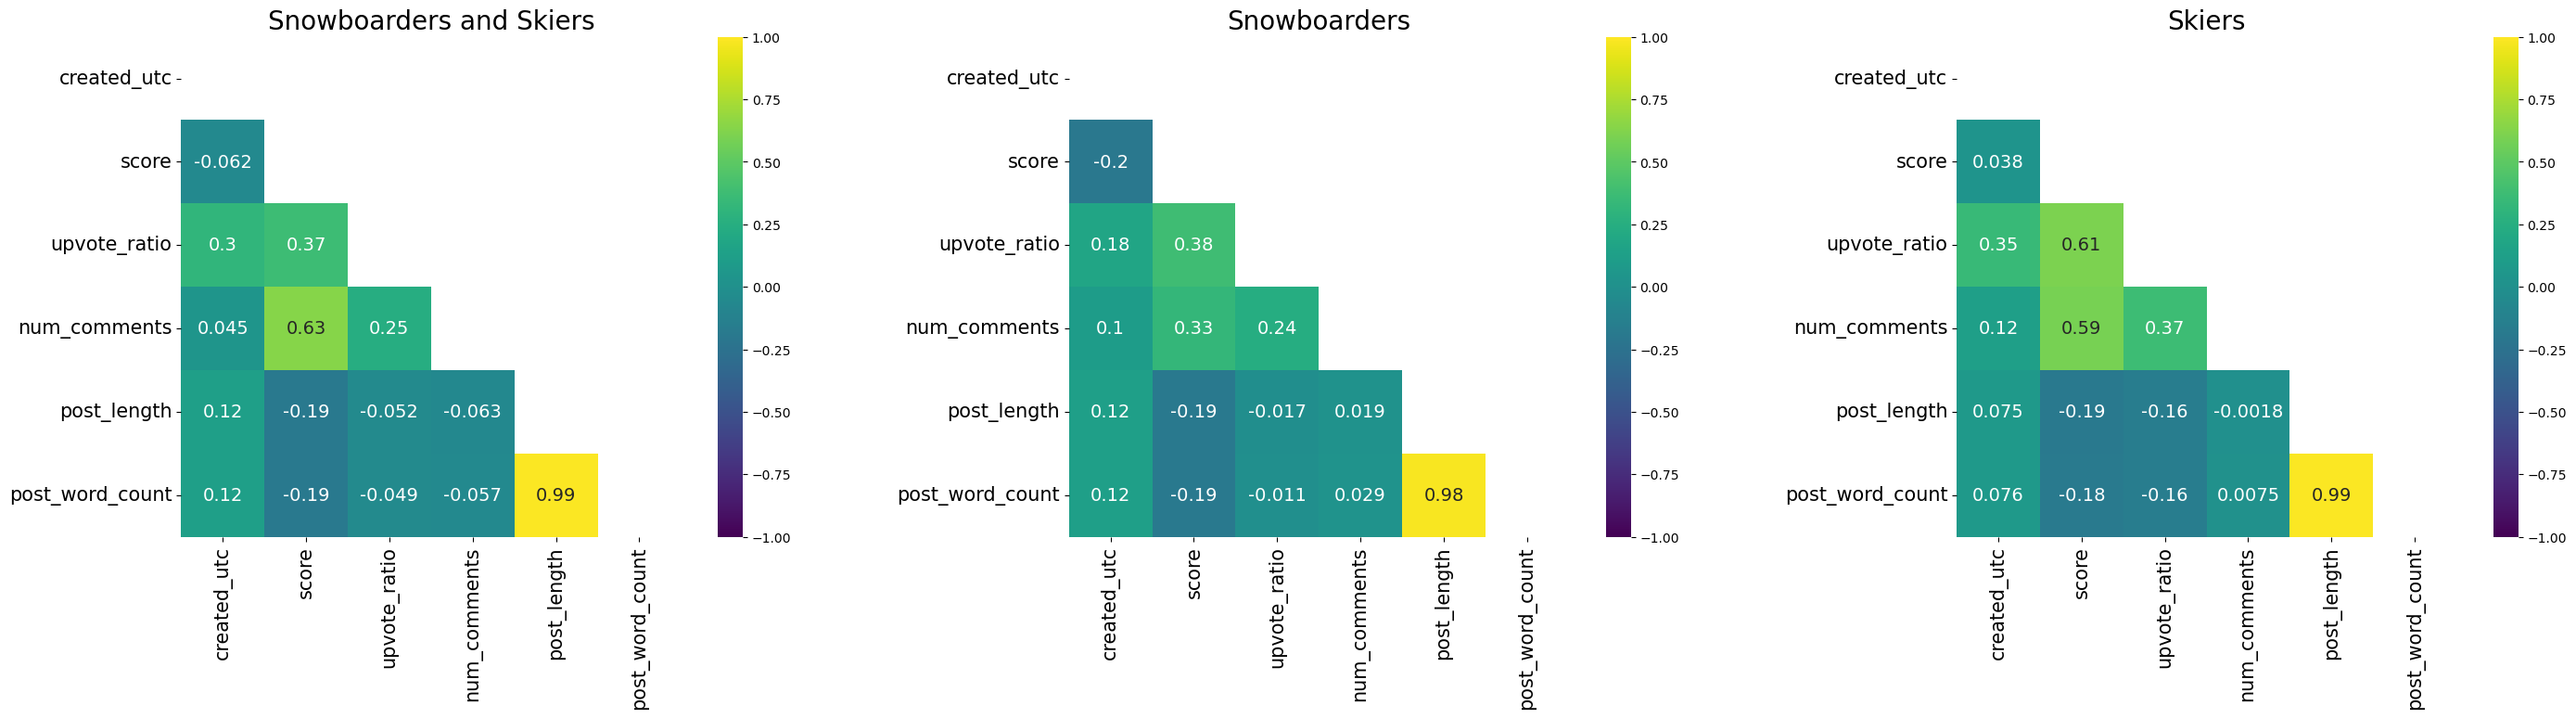

In [25]:
# Adapted from Python Graph Gallery

fig, axs = plt.subplots(1, 3, figsize=(35,7))

corr = df.corr()
# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, 
            mask = mask, 
            square = True, 
            cmap = 'viridis', 
            annot = True, 
            vmin = -1, 
            vmax = 1,
            ax=axs[0],
            annot_kws={
                'fontsize': 15,
                #'fontweight': 'bold'
             });
axs[0].set_title("Snowboarders and Skiers", fontdict={'fontsize': 22})
axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=16)
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=16)

    
corr = snow.corr()
# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, 
            mask = mask, 
            square = True, 
            cmap = 'viridis', 
            annot = True, 
            vmin = -1, 
            vmax = 1,
            ax=axs[1],
            annot_kws={
            'fontsize': 15,
            #'fontweight': 'bold'
             });
axs[1].set_title("Snowboarders", fontdict={'fontsize': 22})
axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=16)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=16)

corr = ski.corr()
# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, 
            mask = mask, 
            square = True, 
            cmap = 'viridis', 
            annot = True, 
            vmin = -1, 
            vmax = 1,
            ax=axs[2],
            annot_kws={
            'fontsize': 15,
            #'fontweight': 'bold'
             });
axs[2].set_title("Skiers", fontdict={'fontsize': 22})
axs[2].set_xticklabels(axs[2].get_xticklabels(), fontsize=16)
axs[2].set_yticklabels(axs[2].get_yticklabels(), fontsize=16)

plt.show();

##### <span style = 'color: blue'>In the snowboarding Reddit community, there was not a strong correlation between score of post and number of comments per post or upvote ratio (R = 0.33 and R = 0.38, respectively). However, the skiing Reddit community had a much stronger correlation between score and these two variables (R = 0.59 and R = 0.61, respectively). This may indicate higher engagement among the skiing Reddit community, potentially leading to a more active and interactive environment including greater propensity to ask questions, seek advice, and engage in discussions related to the content of the posts.</span>

C:\Users\farah\AppData\Local\Temp\ipykernel_25972\673098029.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=14)
C:\Users\farah\AppData\Local\Temp\ipykernel_25972\673098029.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=14)
C:\Users\farah\AppData\Local\Temp\ipykernel_25972\673098029.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_yticklabels(axs[2].get_yticklabels(), fontsize=14)
C:\Users\farah\AppData\Local\Temp\ipykernel_25972\673098029.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_yticklabels(axs[3].get_yticklabels(), fontsize=14)
C:\Users\farah\AppData\Local\Temp\ipykernel_25972\673098029.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[4].set_yticklabels(axs[4].ge

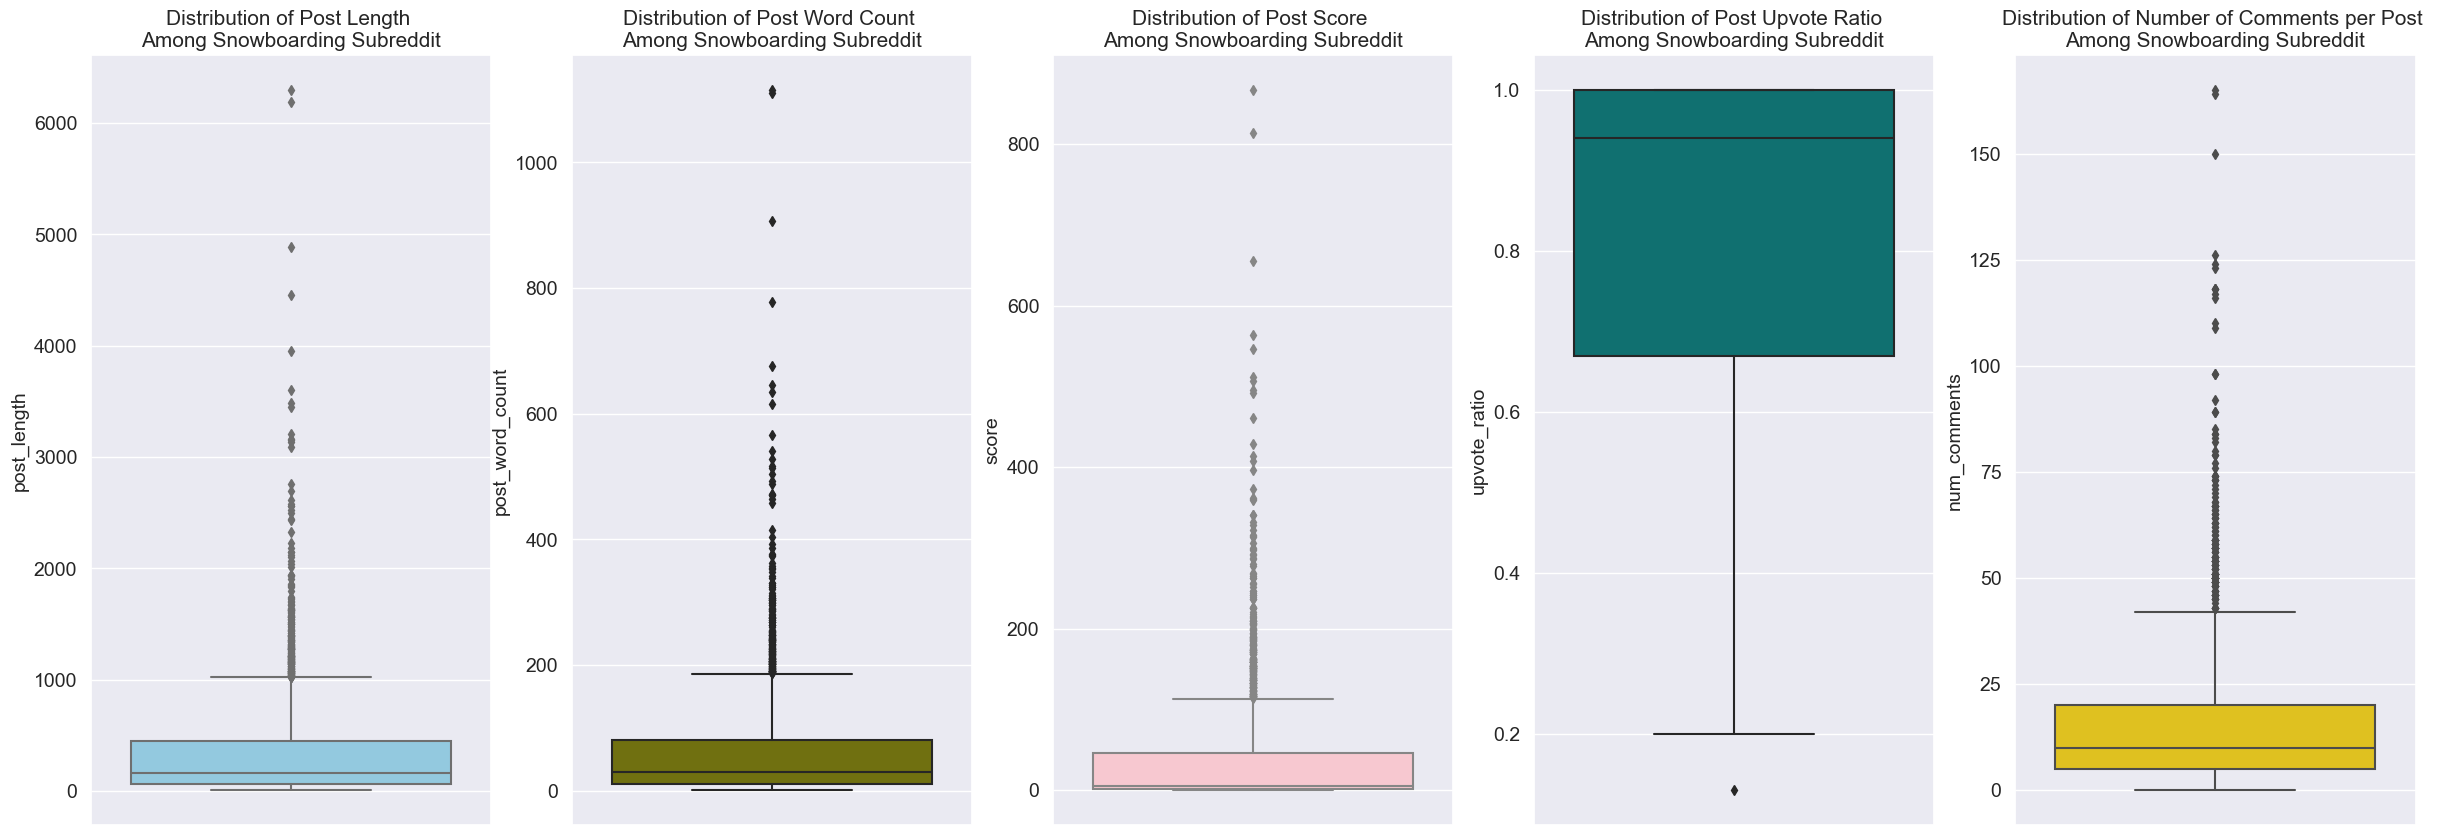

In [26]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 5, figsize=(30, 10))

sns.boxplot(y='post_length', data=snow, color='skyblue', ax=axs[0])
sns.boxplot(y='post_word_count', data=snow, color='olive', ax=axs[1])
sns.boxplot(y='score', data=snow, color='pink', ax=axs[2])
sns.boxplot(y='upvote_ratio', data=snow, color='teal', ax=axs[3])
sns.boxplot(y='num_comments', data=snow, color='gold', ax=axs[4])

axs[0].set_title('Distribution of Post Length \nAmong Snowboarding Subreddit', fontdict={'fontsize': 15})
axs[1].set_title('Distribution of Post Word Count \nAmong Snowboarding Subreddit', fontdict={'fontsize': 15})
axs[2].set_title('Distribution of Post Score \nAmong Snowboarding Subreddit', fontdict={'fontsize': 15})
axs[3].set_title('Distribution of Post Upvote Ratio \nAmong Snowboarding Subreddit', fontdict={'fontsize': 15})
axs[4].set_title('Distribution of Number of Comments per Post \nAmong Snowboarding Subreddit', fontdict={'fontsize': 15})

axs[0].set_ylabel(axs[0].get_ylabel(), fontsize=14)
axs[1].set_ylabel(axs[1].get_ylabel(), fontsize=14)
axs[2].set_ylabel(axs[2].get_ylabel(), fontsize=14)
axs[3].set_ylabel(axs[3].get_ylabel(), fontsize=14)
axs[4].set_ylabel(axs[4].get_ylabel(), fontsize=14)

axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=14)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=14)
axs[2].set_yticklabels(axs[2].get_yticklabels(), fontsize=14)
axs[3].set_yticklabels(axs[3].get_yticklabels(), fontsize=14)
axs[4].set_yticklabels(axs[4].get_yticklabels(), fontsize=14)

plt.show();

C:\Users\farah\AppData\Local\Temp\ipykernel_25972\1473344608.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=14)
C:\Users\farah\AppData\Local\Temp\ipykernel_25972\1473344608.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=14)
C:\Users\farah\AppData\Local\Temp\ipykernel_25972\1473344608.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_yticklabels(axs[2].get_yticklabels(), fontsize=14)
C:\Users\farah\AppData\Local\Temp\ipykernel_25972\1473344608.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_yticklabels(axs[3].get_yticklabels(), fontsize=14)
C:\Users\farah\AppData\Local\Temp\ipykernel_25972\1473344608.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[4].set_yticklabels(axs[

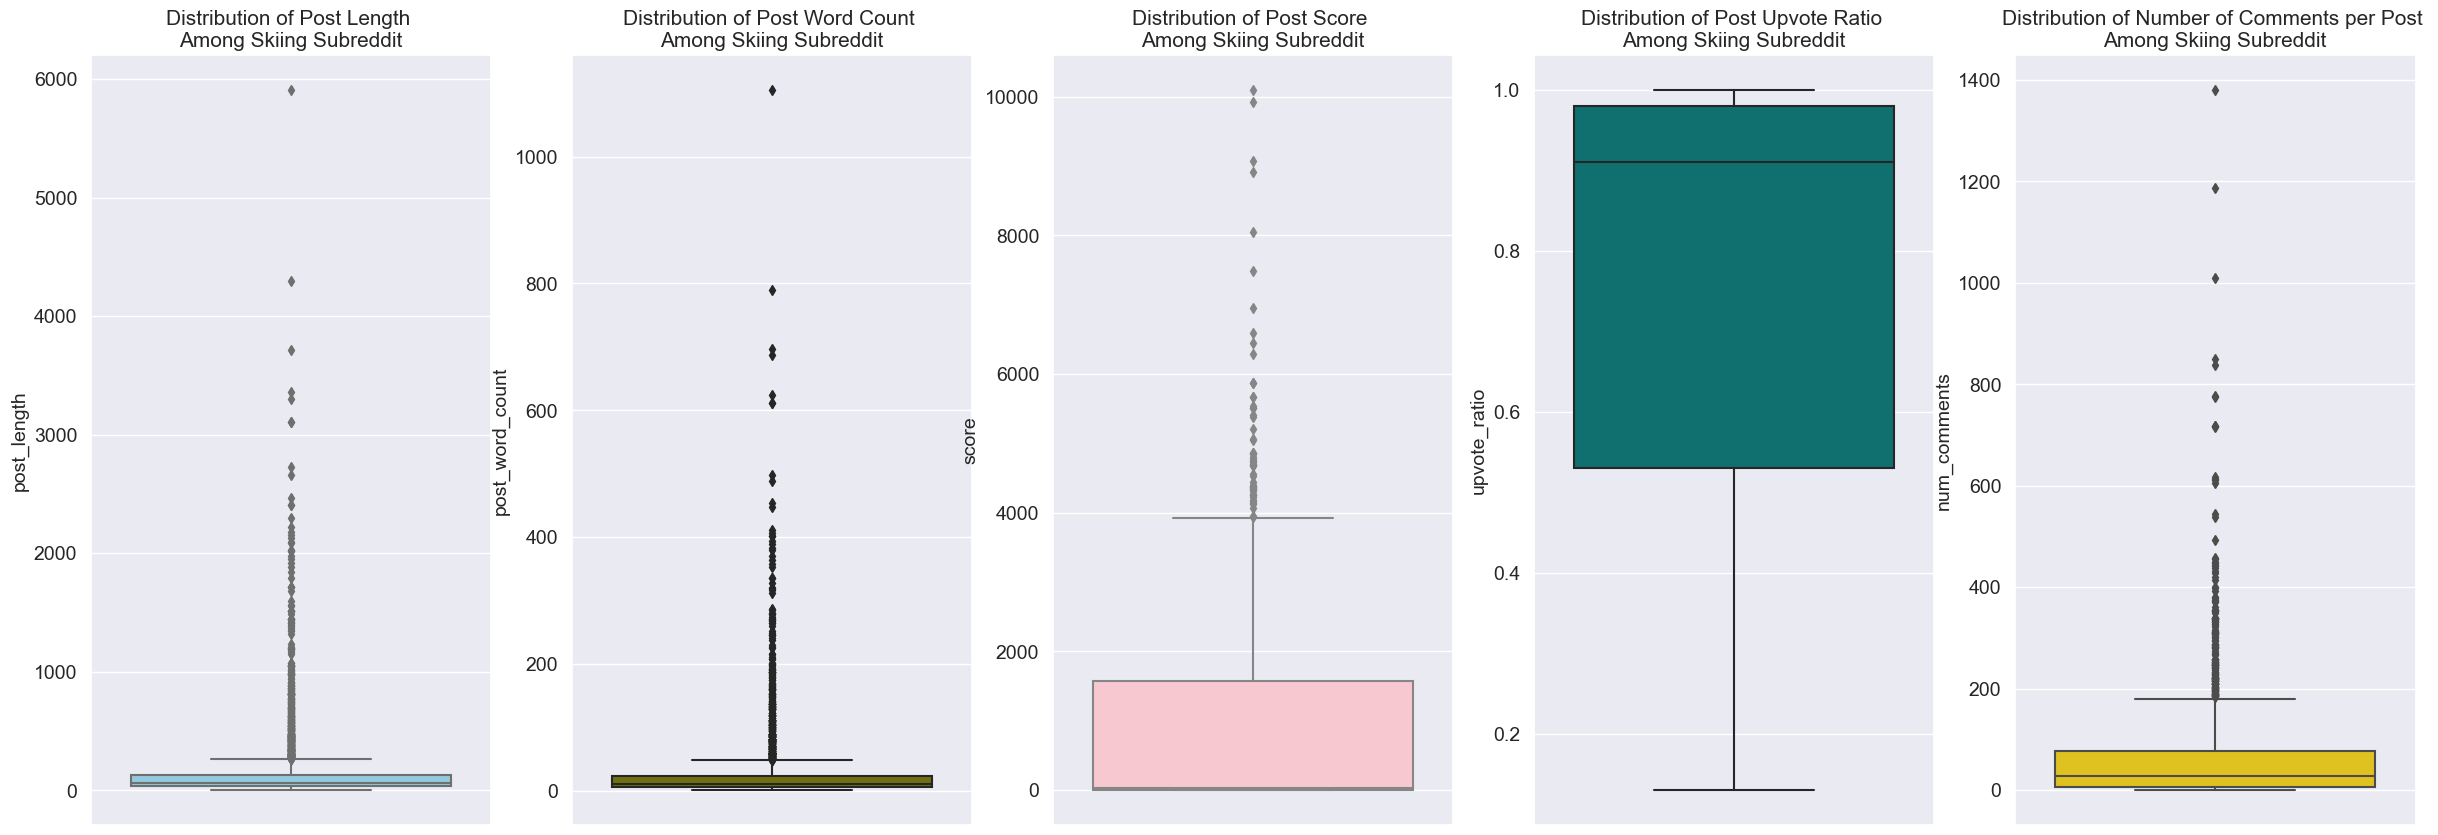

In [27]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(1, 5, figsize=(30, 10))

sns.boxplot(y='post_length', data=ski, color='skyblue', ax=axs[0])
sns.boxplot(y='post_word_count', data=ski, color='olive', ax=axs[1])
sns.boxplot(y='score', data=ski, color='pink', ax=axs[2])
sns.boxplot(y='upvote_ratio', data=ski, color='teal', ax=axs[3])
sns.boxplot(y='num_comments', data=ski, color='gold', ax=axs[4])

axs[0].set_title('Distribution of Post Length \nAmong Skiing Subreddit', fontdict={'fontsize': 15})
axs[1].set_title('Distribution of Post Word Count \nAmong Skiing Subreddit', fontdict={'fontsize': 15})
axs[2].set_title('Distribution of Post Score \nAmong Skiing Subreddit', fontdict={'fontsize': 15})
axs[3].set_title('Distribution of Post Upvote Ratio \nAmong Skiing Subreddit', fontdict={'fontsize': 15})
axs[4].set_title('Distribution of Number of Comments per Post \nAmong Skiing Subreddit', fontdict={'fontsize': 15})

axs[0].set_ylabel(axs[0].get_ylabel(), fontsize=14)
axs[1].set_ylabel(axs[1].get_ylabel(), fontsize=14)
axs[2].set_ylabel(axs[2].get_ylabel(), fontsize=14)
axs[3].set_ylabel(axs[3].get_ylabel(), fontsize=14)
axs[4].set_ylabel(axs[4].get_ylabel(), fontsize=14)

axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=14)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=14)
axs[2].set_yticklabels(axs[2].get_yticklabels(), fontsize=14)
axs[3].set_yticklabels(axs[3].get_yticklabels(), fontsize=14)
axs[4].set_yticklabels(axs[4].get_yticklabels(), fontsize=14)

plt.show();

##### <span style='color:blue'>All variables other than upvote ratio are very right skewed. There is a very large range of post lengths, word counts, scores, and number of comments, but most of the data (75-99%) lie much closer to the minimum. Most variables within the skiing community are much more narrow than that snowboarding community. Post length and word count are generally higher in the snowboarding subreddit, whereas number of comments and the post score is generally higher amongst the skiing subreddit.</span>

In [28]:
# Look at Histograms w/o Outliers (Visually Determined via Boxplots)

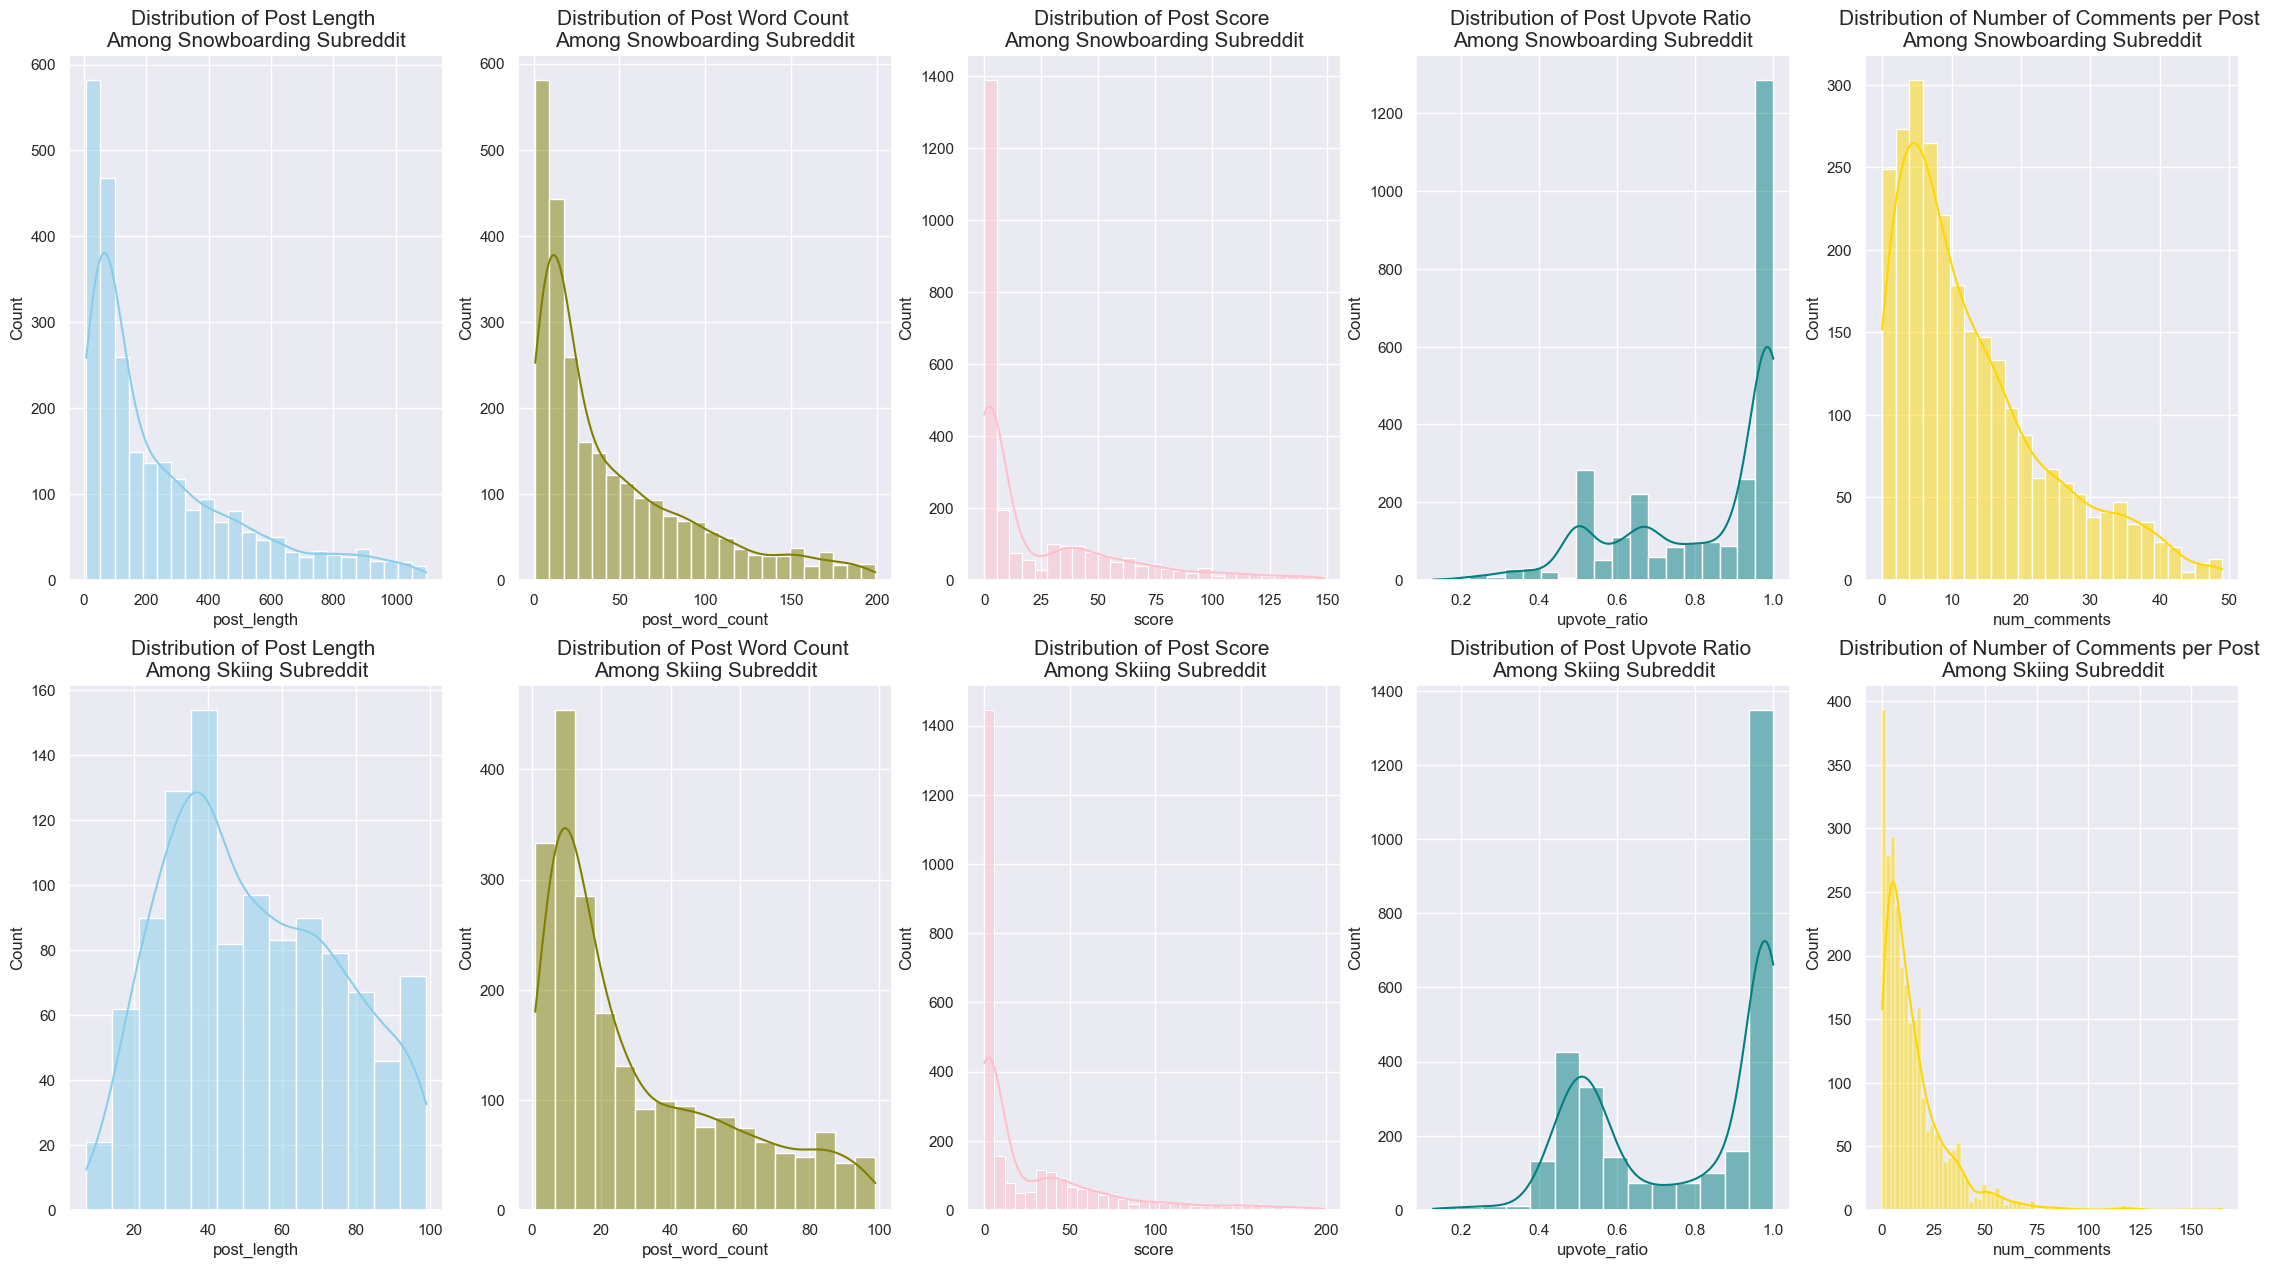

In [29]:
snow_ps_filter = snow[snow.post_length < 1100]
snow_pwc_filter = snow[snow.post_word_count < 200]
snow_scr_filter = snow[snow.score < 150]
snow_com_filter = snow[snow.num_comments < 50]

ski_ps_filter = snow[snow.post_length < 100]
ski_pwc_filter = snow[snow.post_word_count < 100]
ski_scr_filter = snow[snow.score < 200]
ski_com_filter = snow[snow.num_comments < 200]

sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 5, figsize=(28, 15))

sns.histplot(data=snow_ps_filter, x="post_length", kde=True, color="skyblue", ax=axs[0,0])
sns.histplot(data=snow_pwc_filter, x="post_word_count", kde=True, color="olive", ax=axs[0,1])
sns.histplot(data=snow_scr_filter, x="score", kde=True, color="pink", ax=axs[0,2])
sns.histplot(data=snow, x="upvote_ratio", kde=True, color="teal", ax=axs[0,3])
sns.histplot(data=snow_com_filter, x="num_comments", kde=True, color="gold", ax=axs[0,4])

sns.histplot(data=ski_ps_filter, x="post_length", kde=True, color="skyblue", ax=axs[1,0])
sns.histplot(data=ski_pwc_filter, x="post_word_count", kde=True, color="olive", ax=axs[1,1])
sns.histplot(data=ski_scr_filter, x="score", kde=True, color="pink", ax=axs[1,2])
sns.histplot(data=ski, x="upvote_ratio", kde=True, color="teal", ax=axs[1,3])
sns.histplot(data=ski_com_filter, x="num_comments", kde=True, color="gold", ax=axs[1,4])

axs[0,0].set_title('Distribution of Post Length \nAmong Snowboarding Subreddit', fontdict={'fontsize': 15})
axs[0,1].set_title('Distribution of Post Word Count \nAmong Snowboarding Subreddit', fontdict={'fontsize': 15});
axs[0,2].set_title('Distribution of Post Score \nAmong Snowboarding Subreddit', fontdict={'fontsize': 15});
axs[0,3].set_title('Distribution of Post Upvote Ratio \nAmong Snowboarding Subreddit', fontdict={'fontsize': 15});
axs[0,4].set_title('Distribution of Number of Comments per Post \nAmong Snowboarding Subreddit', fontdict={'fontsize': 15});

axs[1,0].set_title('Distribution of Post Length \nAmong Skiing Subreddit', fontdict={'fontsize': 15})
axs[1,1].set_title('Distribution of Post Word Count \nAmong Skiing Subreddit', fontdict={'fontsize': 15});
axs[1,2].set_title('Distribution of Post Score \nAmong Skiing Subreddit', fontdict={'fontsize': 15});
axs[1,3].set_title('Distribution of Post Upvote Ratio \nAmong Skiing Subreddit', fontdict={'fontsize': 15});
axs[1,4].set_title('Distribution of Number of Comments per Post \nAmong Skiing Subreddit', fontdict={'fontsize': 15});

plt.show()

##### <span style='color:blue'>When taking out extreme values, all variables are still right skewed except upvote ratio. As was seen in the prior boxplots, the snowboarding community has more long posts and higher word counts, whereas number of comments and scores of the post are generally higher in the skiing community group.</span>

## IV. User-Level Exploration

In [30]:
# Look at user level
snow['dummy'] = 1

snow_ids = snow.groupby('author').agg({
    'post_length': 'mean',
    'post_word_count': 'mean',
    'score': 'mean',
    'num_comments': 'mean',
    'dummy': 'count'
}).reset_index().rename(columns = {'post_length': 'postlen_mean', 'post_word_count': 'pwc_mean', 'score': 'score_mean', 'num_comments': 'comm_mean', 'dummy': 'count'})

snow_ids['subreddit'] = "snowboardingnoobs"

In [31]:
ski['dummy'] = 1

ski_ids = ski.groupby('author').agg({
    'post_length': 'mean',
    'post_word_count': 'mean',
    'score': 'mean',
    'num_comments': 'mean',
    'dummy': 'count'
}).reset_index().rename(columns = {'post_length': 'postlen_mean', 'post_word_count': 'pwc_mean', 'score': 'score_mean', 'num_comments': 'comm_mean', 'dummy': 'count'})

ski_ids['subreddit'] = "skiing"

In [32]:
print(f'Snowboarding Subreddit: {snow.shape[0]} posts among {snow_ids.shape[0]} authors')
print(f'Skiing Subreddit: {ski.shape[0]} posts among {ski_ids.shape[0]} authors')

Snowboarding Subreddit: 2748 posts among 1966 authors
Skiing Subreddit: 2888 posts among 2152 authors


In [33]:
snow_ids.sort_values(by='count', ascending=False).head(10)

,author,postlen_mean,pwc_mean,score_mean,comm_mean,count,subreddit
494,Johnathanbuckhouse,57.291667,10.125000,14.375000,4.041667,24,snowboardingnoobs
1890,twinbee,756.350000,135.450000,18.750000,29.900000,20,snowboardingnoobs
1200,canuck-dirk,177.833333,33.500000,118.583333,27.750000,12,snowboardingnoobs
495,Johnny_snipes,81.454545,14.909091,16.818182,2.090909,11,snowboardingnoobs
751,PirateboarderLife,93.800000,16.100000,35.800000,6.600000,10,snowboardingnoobs
506,Jxh57601206,250.500000,46.500000,15.200000,17.700000,10,snowboardingnoobs
337,Fall_Ace,463.875000,87.625000,36.750000,16.000000,8,snowboardingnoobs
1459,kdawg2894,134.125000,25.500000,55.875000,8.750000,8,snowboardingnoobs
1180,bnny_rbbt,338.857143,67.857143,5.428571,14.714286,7,snowboardingnoobs
846,SeafoamCoast,812.142857,156.714286,47.000000,23.857143,7,snowboardingnoobs


In [34]:
ski_ids.sort_values(by='count', ascending=False).head(10)

,author,postlen_mean,pwc_mean,score_mean,comm_mean,count,subreddit
1664,maltamur,48.384615,8.807692,1571.615385,73.153846,26,skiing
311,EverestMaher,106.130435,16.826087,742.739130,228.565217,23,skiing
786,Robertsimpsion,400.625000,60.125000,5.937500,9.750000,16,skiing
1415,funpow,46.625000,8.562500,2376.062500,98.312500,16,skiing
479,JonBoah,43.181818,7.818182,149.454545,22.090909,11,skiing
809,SalesMountaineer,87.200000,15.900000,248.400000,42.600000,10,skiing
823,Senditserg,44.900000,9.100000,1711.300000,79.900000,10,skiing
2076,twomoments,47.700000,9.000000,1742.500000,81.300000,10,skiing
259,DestroyedLolo,72.300000,14.200000,15.200000,2.300000,10,skiing
164,C0-0P,58.000000,11.400000,561.100000,66.600000,10,skiing


In [35]:
# See if any of the authors are the same

ids = pd.concat([snow_ids, ski_ids], axis = 0)
ids.shape

(4118, 7)

In [36]:
chk = ids.drop_duplicates(subset=['author'])
f'{ids.shape[0] - chk.shape[0]} overlapping authors between the two communities, :)'

'9 overlapping authors between the two communities, :)'

In [37]:
ids.describe()

,postlen_mean,pwc_mean,score_mean,comm_mean,count
count,4118.000000,4118.000000,4118.000000,4118.000000,4118.000000
mean,253.604508,45.935420,414.218915,36.656272,1.317387
std,406.295777,73.453393,896.719924,64.659965,1.172946
min,4.000000,1.000000,0.000000,0.000000,1.000000
25%,43.000000,8.000000,1.000000,6.000000,1.000000
50%,93.000000,17.000000,10.000000,15.000000,1.000000
75%,308.000000,56.500000,150.750000,39.000000,1.000000
max,6187.000000,1115.000000,10099.000000,1010.000000,26.000000


In [38]:
snow_ids.describe()

,postlen_mean,pwc_mean,score_mean,comm_mean,count
count,1966.000000,1966.000000,1966.000000,1966.000000,1966.000000
mean,345.440152,62.304460,33.653692,15.204817,1.343337
std,450.330026,80.415554,63.515293,15.826355,1.107285
min,8.000000,1.000000,0.000000,0.000000,1.000000
25%,66.000000,12.000000,1.000000,5.000000,1.000000
50%,184.500000,34.000000,5.000000,11.000000,1.000000
75%,466.000000,84.750000,43.000000,20.187500,1.000000
max,6187.000000,1115.000000,867.000000,165.000000,24.000000


In [39]:
ski_ids.describe()

,postlen_mean,pwc_mean,score_mean,comm_mean,count
count,2152.000000,2152.000000,2152.000000,2152.000000,2152.00000
mean,169.706331,30.981176,761.891418,56.253651,1.29368
std,340.504484,62.854185,1132.282452,83.478130,1.22965
min,4.000000,1.000000,0.000000,0.000000,1.00000
25%,35.187500,6.000000,1.000000,7.000000,1.00000
50%,62.000000,11.000000,24.000000,28.000000,1.00000
75%,146.125000,27.000000,1531.625000,74.000000,1.00000
max,5907.000000,1105.000000,10099.000000,1010.000000,26.00000


In [40]:
snow_descrip = snow_ids.describe().loc['mean'].to_frame().T #source: https://datascientyst.com/append-pandas-series-dataframe/
ski_descrip = ski_ids.describe().loc['mean'].to_frame().T

In [41]:
snow_descrip['subreddit'] = 'Snowboarding'
ski_descrip['subreddit'] = 'Skiing'

snow_descrip['community'] = 'Community'
ski_descrip['community'] = 'Community'

In [42]:
descrips = pd.concat([snow_descrip, ski_descrip], axis=0)

In [43]:
descrips

,postlen_mean,pwc_mean,score_mean,comm_mean,count,subreddit,community
mean,345.440152,62.304460,33.653692,15.204817,1.343337,Snowboarding,Community
mean,169.706331,30.981176,761.891418,56.253651,1.293680,Skiing,Community


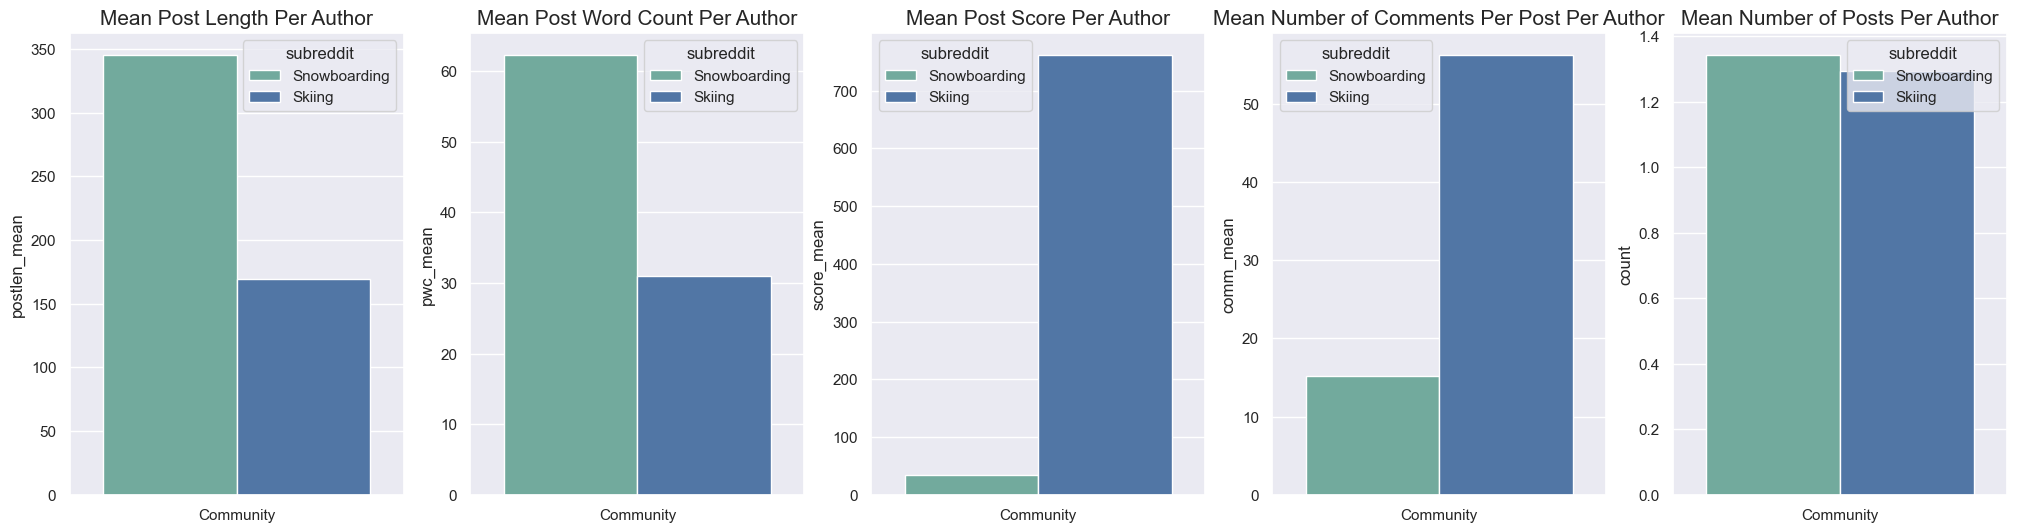

In [44]:
# Create an array with the colors you want to use
colors = ["#69b3a2", "#4374B3"]
sns.set_palette(sns.color_palette(colors))


# Set the figure size
#plt.figure(figsize=(3, 4))
fig, axs = plt.subplots(1, 5, figsize=(25, 6))

# grouped barplot
ax = sns.barplot(
    x="community", 
    y="postlen_mean", 
    hue="subreddit", 
    data=descrips, 
    errorbar=None,
    ax=axs[0]
    );

ax = sns.barplot(
    x="community", 
    y="pwc_mean", 
    hue="subreddit", 
    data=descrips, 
    errorbar=None,
    ax=axs[1]
    );

ax = sns.barplot(
    x="community", 
    y="score_mean", 
    hue="subreddit", 
    data=descrips, 
    errorbar=None,
    ax=axs[2]
    );

ax = sns.barplot(
    x="community", 
    y="comm_mean", 
    hue="subreddit", 
    data=descrips, 
    errorbar=None,
    ax=axs[3]
    );

ax = sns.barplot(
    x="community", 
    y="count", 
    hue="subreddit", 
    data=descrips, 
    errorbar=None,
    ax=axs[4]
    );

axs[0].set_title('Mean Post Length Per Author', fontdict={'fontsize': 15})
axs[1].set_title('Mean Post Word Count Per Author', fontdict={'fontsize': 15});
axs[2].set_title('Mean Post Score Per Author', fontdict={'fontsize': 15});
axs[3].set_title('Mean Number of Comments Per Post Per Author', fontdict={'fontsize': 15});
axs[4].set_title('Mean Number of Posts Per Author', fontdict={'fontsize': 15});

for ax in axs:
    ax.set_xlabel(None)
    
#plt.legend(bbox_to_anchor=(1.02, 0.95), loc='upper center', borderaxespad=0, title = 'Subreddit Community' ); 

##### <span style='color:blue'>We pulled 2,748 posts from the Snowboarding subreddit community and 2,888 posts from the Skiing subreddit community. The 2,748 posts were posted by 1,966 unique authors, and the 2,888 post were posted by 2,152 unique authors. Therefore, as seen in the last barplot, the number of posts per author was slightly higher in the Snowboarding subreddit. </span>
    
##### <span style='color:blue'>The average length of a post per author was larger in the Snowboarding subreddit than the Skiing subreddit by almost 200 characters; and each authors average words per post was also higher by approximately 30 words. However, we know there is a large right skew, so these means are inflated. The Skiing subreddit's authors had a higher average score and number of comments per post.</span>

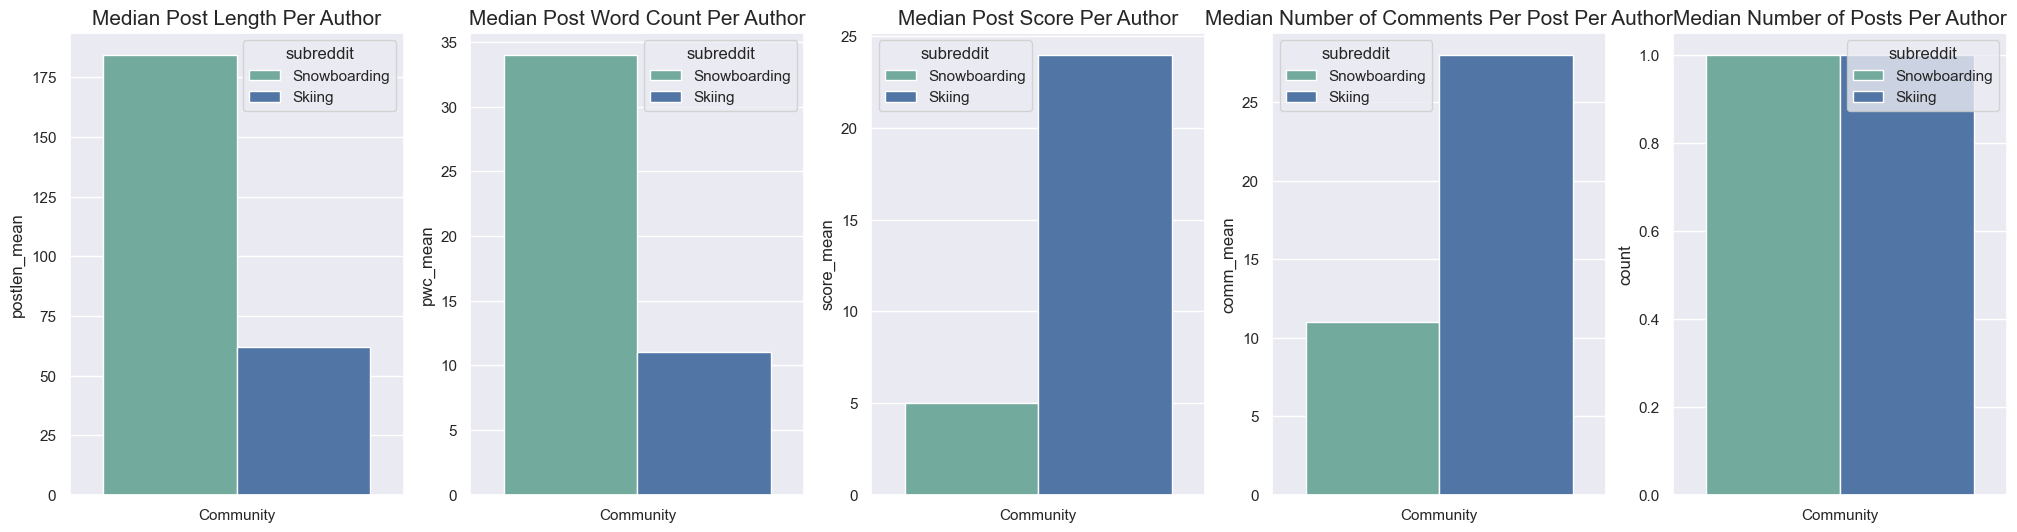

In [45]:
# Adapted from Python Graph Gallery: https://www.python-graph-gallery.com/grouped-barplot/

snow_descrip = snow_ids.describe().loc['50%'].to_frame().T #source: https://datascientyst.com/append-pandas-series-dataframe/
ski_descrip = ski_ids.describe().loc['50%'].to_frame().T

# Create an array with the colors you want to use
colors = ["#69b3a2", "#4374B3"]
sns.set_palette(sns.color_palette(colors))

snow_descrip['subreddit'] = 'Snowboarding'
ski_descrip['subreddit'] = 'Skiing'

snow_descrip['community'] = 'Community'
ski_descrip['community'] = 'Community'

descrips_med = pd.concat([snow_descrip, ski_descrip], axis=0)


# Set the figure size
#plt.figure(figsize=(3, 4))
fig, axs = plt.subplots(1, 5, figsize=(25, 6))

# grouped barplot
ax = sns.barplot(
    x="community", 
    y="postlen_mean", 
    hue="subreddit", 
    data=descrips_med, 
    errorbar=None,
    ax=axs[0]
    );

ax = sns.barplot(
    x="community", 
    y="pwc_mean", 
    hue="subreddit", 
    data=descrips_med, 
    errorbar=None,
    ax=axs[1]
    );

ax = sns.barplot(
    x="community", 
    y="score_mean", 
    hue="subreddit", 
    data=descrips_med, 
    errorbar=None,
    ax=axs[2]
    );

ax = sns.barplot(
    x="community", 
    y="comm_mean", 
    hue="subreddit", 
    data=descrips_med, 
    errorbar=None,
    ax=axs[3]
    );

ax = sns.barplot(
    x="community", 
    y="count", 
    hue="subreddit", 
    data=descrips_med, 
    errorbar=None,
    ax=axs[4]
    );

axs[0].set_title('Median Post Length Per Author', fontdict={'fontsize': 15})
axs[1].set_title('Median Post Word Count Per Author', fontdict={'fontsize': 15});
axs[2].set_title('Median Post Score Per Author', fontdict={'fontsize': 15});
axs[3].set_title('Median Number of Comments Per Post Per Author', fontdict={'fontsize': 15});
axs[4].set_title('Median Number of Posts Per Author', fontdict={'fontsize': 15});

for ax in axs:
    ax.set_xlabel(None)
    
#plt.legend(bbox_to_anchor=(1.02, 0.95), loc='upper center', borderaxespad=0, title = 'Subreddit Community' ); 

##### <span style='color:blue'>When looking at medians, we observe the same trends as when looking at means, but not to the same magnitude. Snowboarding authors are more likely to post longer messages in both number of characters and words, whereas Skiing authors are more likely to engage by upvoting posts and commenting on them.</span>

## V. Text / Language Processing and Exploration

In [46]:
# Function for Lemmatizing
def lemmatize_txt(text):
    
    tokenizer = RegexpTokenizer('\w+')
    split_txt = tokenizer.tokenize(text)

    # Instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
        
    # Lemmatize and Rejoin
    return ' '.join([lemmatizer.lemmatize(word) for word in split_txt])

In [47]:
# Function for Stemming
def stem_txt(text):
    
    tokenizer = RegexpTokenizer('\w+')
    split_txt = tokenizer.tokenize(text)

    # Instantiate Stemmer
    p_stemmer = PorterStemmer()

    # Stem and Rejoin
    return ' '.join([p_stemmer.stem(word) for word in split_txt])

In [80]:
def cvectorize(df, stopwrd, gram, title, clr):

    # Built-in English stopwords
    english_stopwords = CountVectorizer(stop_words='english').get_stop_words() # source: https://scikit-learn-ts-git-feature-docs-2-saasify.vercel.app/docs/classes/CountVectorizer
    custom_words = stopwrd

    # Combine English stopwords with the custom stopwords
    stopwords = list(english_stopwords) + custom_words

    cvec = CountVectorizer(stop_words=stopwords,
                           preprocessor=lemmatize_txt,
                           ngram_range=gram,
                          )
    X_vect = cvec.fit_transform(df['text'])
    X_vect.todense()
    X_vect_df = pd.DataFrame(data = X_vect.todense(), 
                             columns = cvec.get_feature_names_out())

    plt.figure(figsize=(8,10))
    plt.title(title)
    return X_vect_df.sum().sort_values(ascending=False).head(50).plot(kind = 'barh', width=0.8, color=clr);

### Top Unigrams, Bigrams, Trigrams by Activity

C:\Users\farah\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le'] not in stop_words.
  warnings.warn(


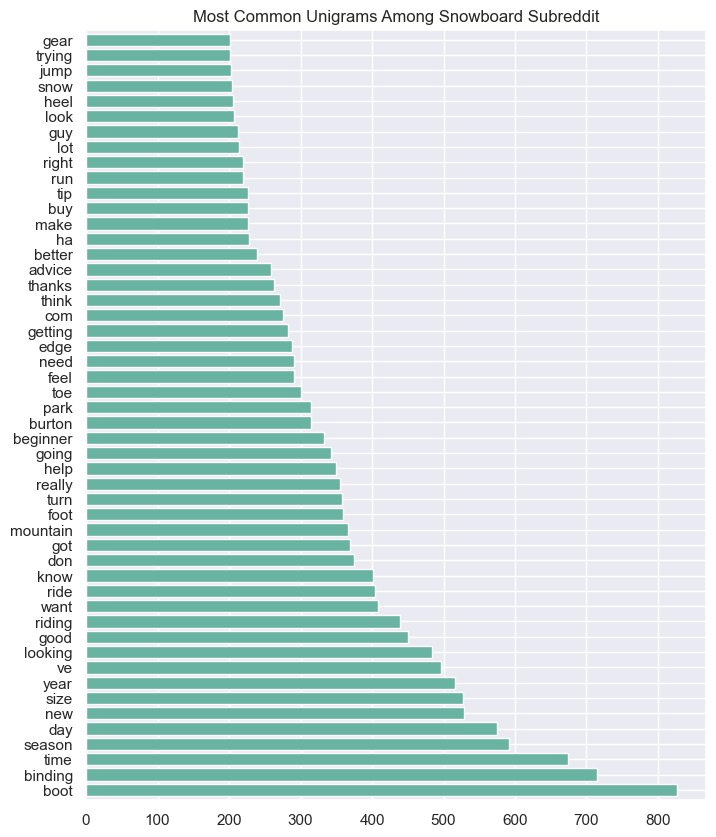

In [81]:
cvectorize(snow, 
           ['snowboard', 'snowboarding', 'board', 'ski', 'skier', 'skiing', 'skis', 'just', 'like', 'wa', 'http', 'https', 'www', 'reddit', 'subreddit'], 
           (1,1), 
           "Most Common Unigrams Among Snowboard Subreddit",
           "#69b3a2");

##### <span style = 'color: blue'> Top words among the snowboarding community appear to potentially align more with gear and performance, or the experience **in or during** the activity. Notable words among the Top 50 include, boot, binding, gear, mountain, Burton, heel, toe, edge, and jump.</span>

C:\Users\farah\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le'] not in stop_words.
  warnings.warn(


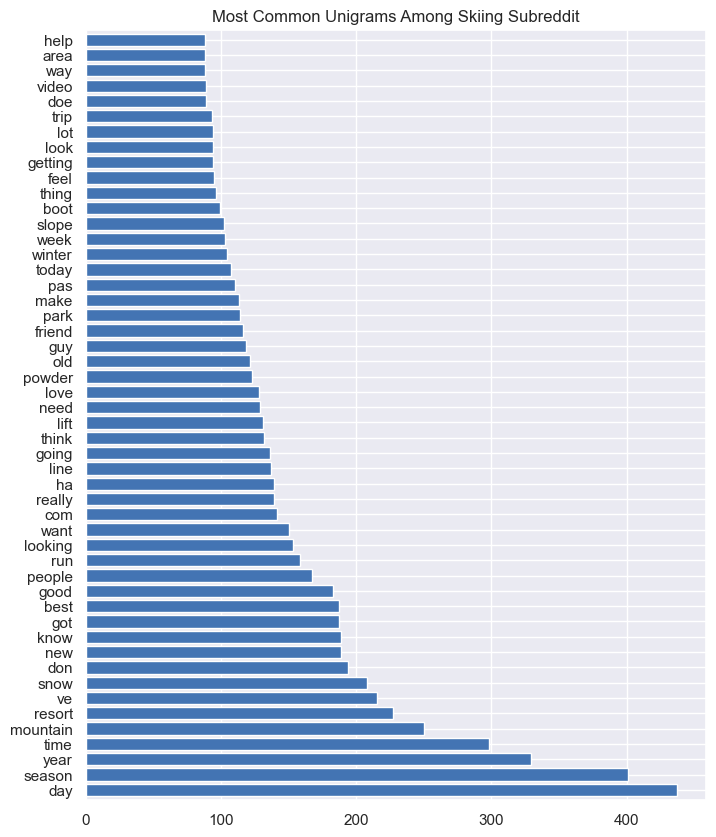

In [82]:
cvectorize(ski, ['snowboard', 'snowboarding', 'board', 'ski', 'skier', 'skiing', 'skis', 'just', 'like', 'wa', 'http', 'https', 'www', 'reddit', 'subreddit'], (1,1), "Most Common Unigrams Among Skiing Subreddit", "#4374B3");

##### <span style = 'color: blue'> Top words among the skiing community appear to potentially align more the experience **around** the activity, such as the best place to go or best time of year. Notable words among the Top 50 include, day, season, time, year, week, resort, powder, and trip.</span>

C:\Users\farah\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le'] not in stop_words.
  warnings.warn(


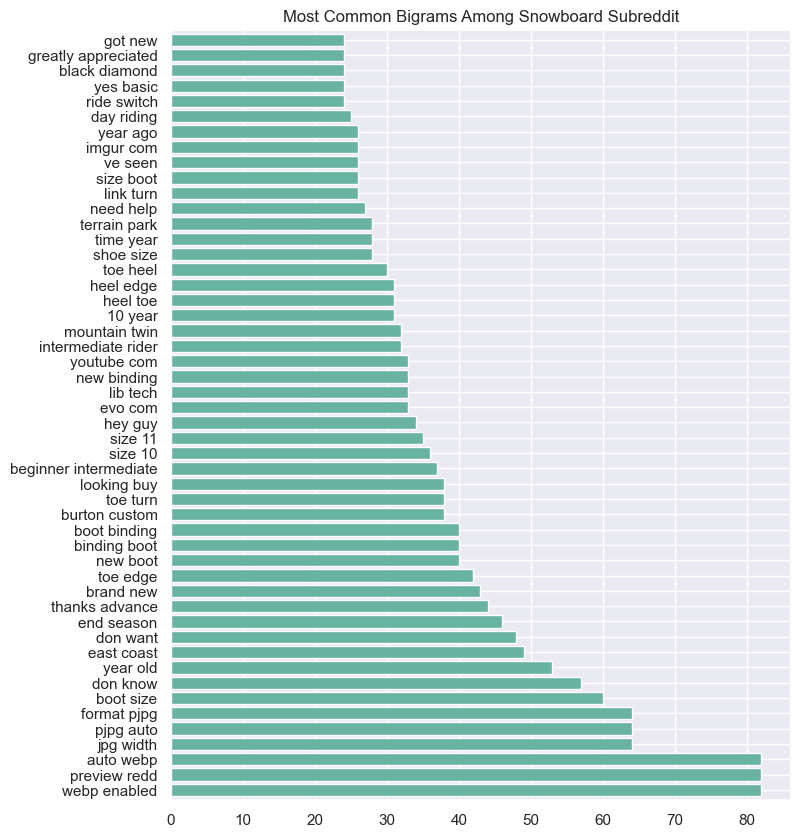

In [83]:
cvectorize(snow, ['snowboard', 'snowboarding', 'board', 'ski', 'skier', 'skiing', 'skis', 'just', 'like', 'wa', 'http', 'https', 'www', 'reddit', 'subreddit'], (2,2), "Most Common Bigrams Among Snowboard Subreddit", "#69b3a2");

##### <span style = 'color: blue'> Top bigrams among the snowboarding community also appear to potentially align more with gear and performance, such as Burton custom, toe edge, binding boot, new boot, shoe sizes, heel toe, ride switch, black diamond, and terrain park.</span>

C:\Users\farah\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le'] not in stop_words.
  warnings.warn(


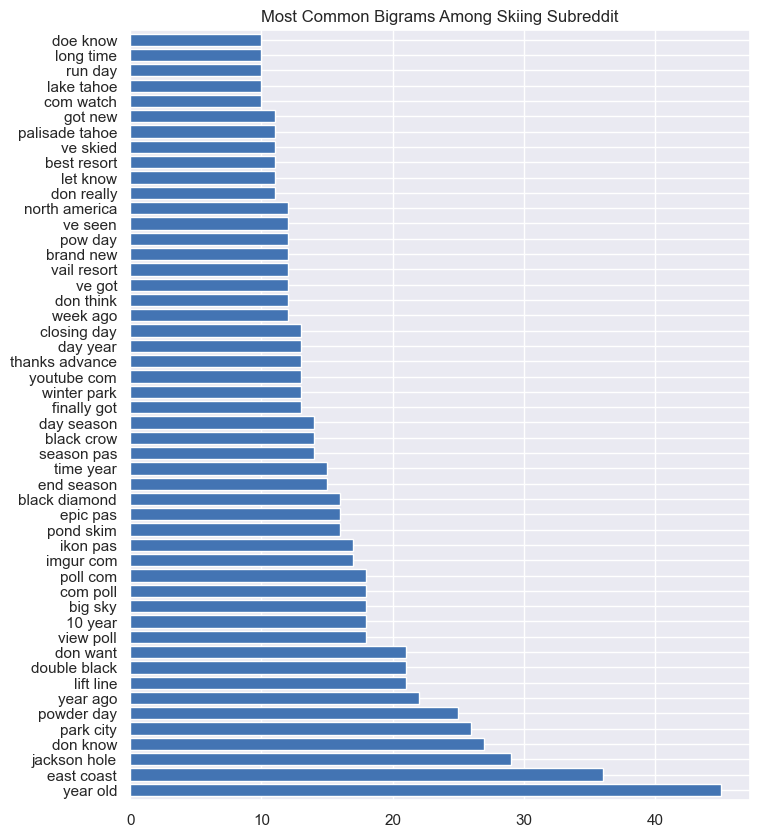

In [84]:
cvectorize(ski, ['snowboard', 'snowboarding', 'board', 'ski', 'skier', 'skiing', 'skis', 'just', 'like', 'wa', 'http', 'https', 'www', 'reddit', 'subreddit'], (2,2), "Most Common Bigrams Among Skiing Subreddit", "#4374B3");

##### <span style = 'color: blue'> Top bigrams among the skiing community mention many places, such as east coast, North America, Jackson Hole, Park City, Winter Park, Palisade Tahoe, Lake Tahoe, Vail resort, best resort. They also mention the best passes, such as epic pass, season pass, Ikon pass, and gear such as Black Crow, as well as activities such as pond skim.</span>

C:\Users\farah\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le'] not in stop_words.
  warnings.warn(


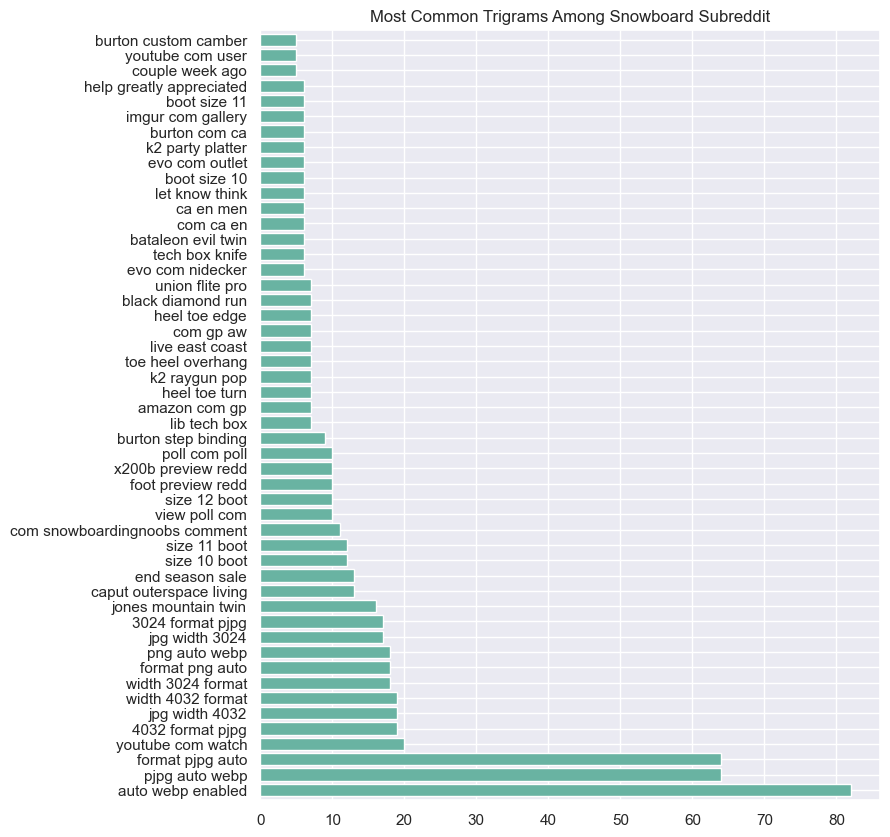

In [85]:
cvectorize(snow, ['snowboard', 'snowboarding', 'board', 'ski', 'skier', 'skiing', 'skis', 'just', 'like', 'wa', 'http', 'https', 'www', 'reddit', 'subreddit'], (3,3), "Most Common Trigrams Among Snowboard Subreddit", "#69b3a2");

C:\Users\farah\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le'] not in stop_words.
  warnings.warn(


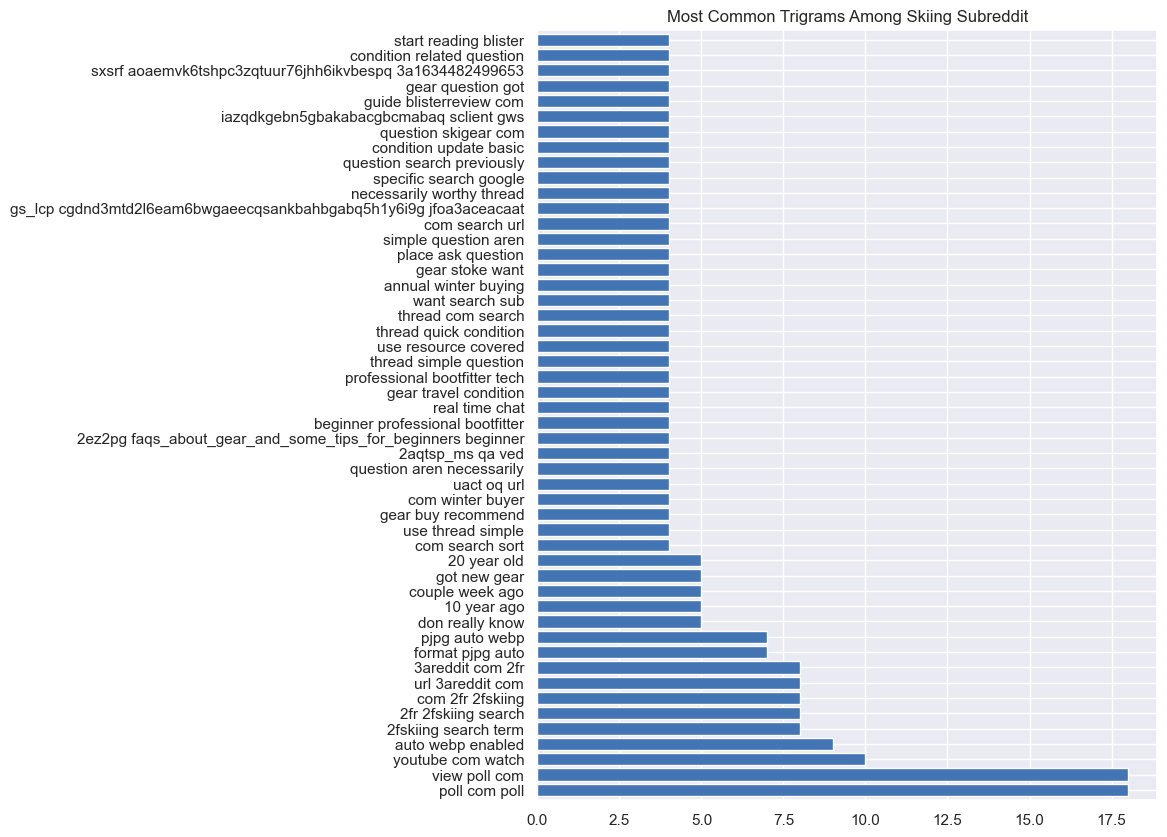

In [86]:
cvectorize(ski, ['snowboard', 'snowboarding', 'board', 'ski', 'skier', 'skiing', 'skis', 'just', 'like', 'wa', 'http', 'https', 'www', 'reddit', 'subreddit'], (3,3), "Most Common Trigrams Among Skiing Subreddit", "#4374B3");

In [ ]:
cvectorize(df, ['snowboard', 'snowboarding', 'board', 'ski', 'skier', 'skiing', 'skis', 'just', 'like', 'wa', 'http', 'https', 'www', 'reddit', 'subreddit'], (1,1), "Most Common Unigrams Among Snowing + Skiing Subreddit", "lightcoral");

### Most Common Words by Top 25% of Upvoted Posts

In [88]:
# Get Top Words for Top 25% Most Upvoted Posts
snow_score_75 = snow[snow.score >= snow.score.quantile(0.75)]
ski_score_75 = ski[ski.score >= snow.score.quantile(0.75)]
# score_75 = df[df.score >= df.score.quantile(0.75)] --> had imbalanced classes (89% skiing), so will append top25% from snowboarding and top25% from skiing instead
score_75 = pd.concat([snow_score_75, ski_score_75], axis=0)

C:\Users\farah\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le'] not in stop_words.
  warnings.warn(


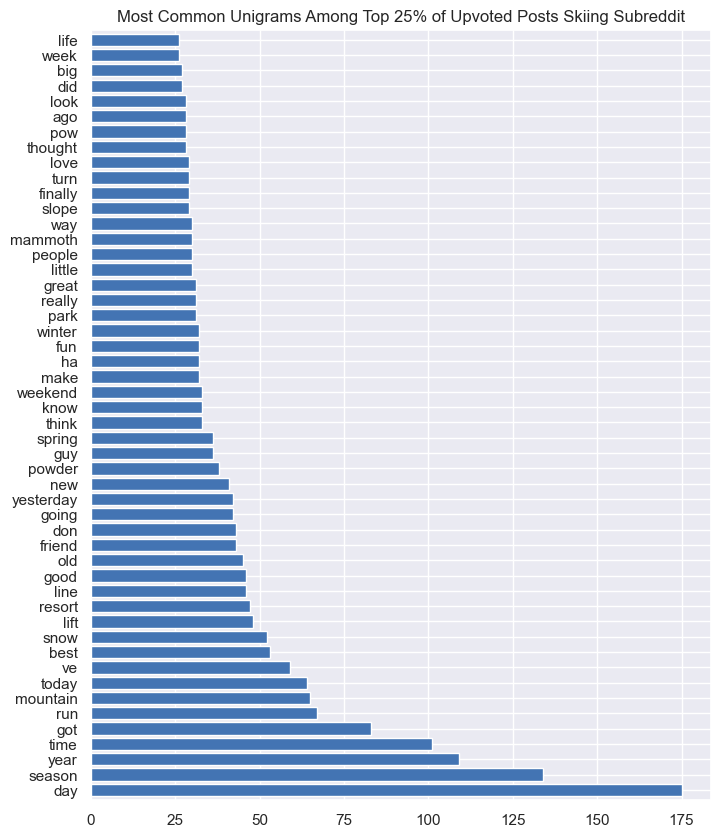

In [89]:
cvectorize(ski_score_75, ['snowboard', 'snowboarding', 'board', 'ski', 'skier', 'skiing', 'skis', 'just', 'like', 'wa', 'http', 'https', 'www', 'reddit', 'subreddit'], (1,1), "Most Common Unigrams Among Top 25% of Upvoted Posts Skiing Subreddit", "#4374B3");

##### <span style = 'color: blue'> Notable words among the Top 25% Upvoted posts for skiers included those around time of year and place to go skiing, Mammoth Mountain appears in these posts for the first time (did not appear in overall unigrams or bigrams top words). </span>

C:\Users\farah\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le'] not in stop_words.
  warnings.warn(


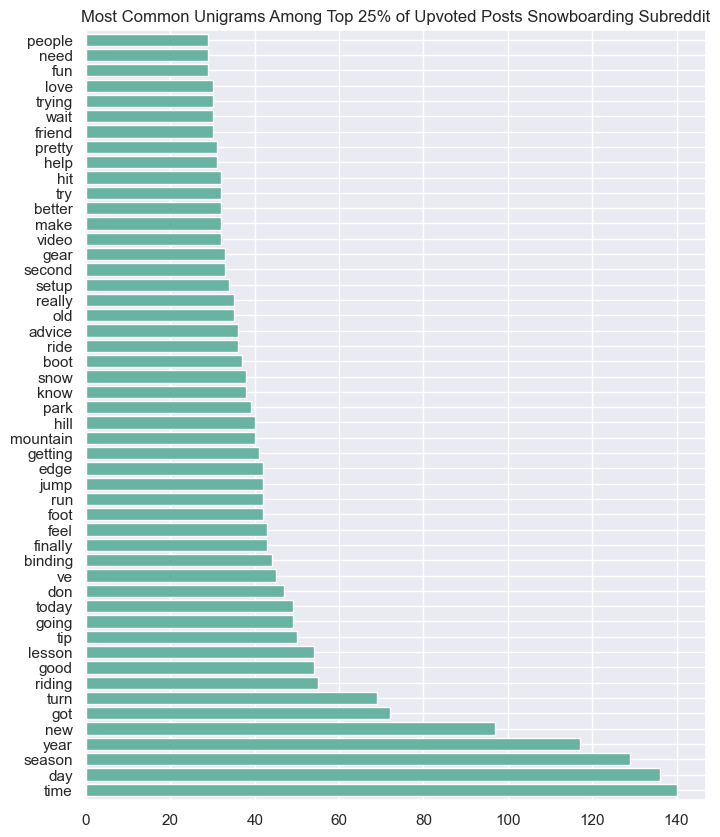

In [90]:
cvectorize(snow_score_75, ['snowboard', 'snowboarding', 'board', 'ski', 'skier', 'skiing', 'skis', 'just', 'like', 'wa', 'http', 'https', 'www', 'reddit', 'subreddit'], (1,1), "Most Common Unigrams Among Top 25% of Upvoted Posts Snowboarding Subreddit", "#69b3a2");

##### <span style = 'color: blue'> Notable words among the Top 25% Upvoted posts for snowboarders included those around time of year and technique, such as heel, toe, edge, and jump. </span>

C:\Users\farah\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le'] not in stop_words.
  warnings.warn(


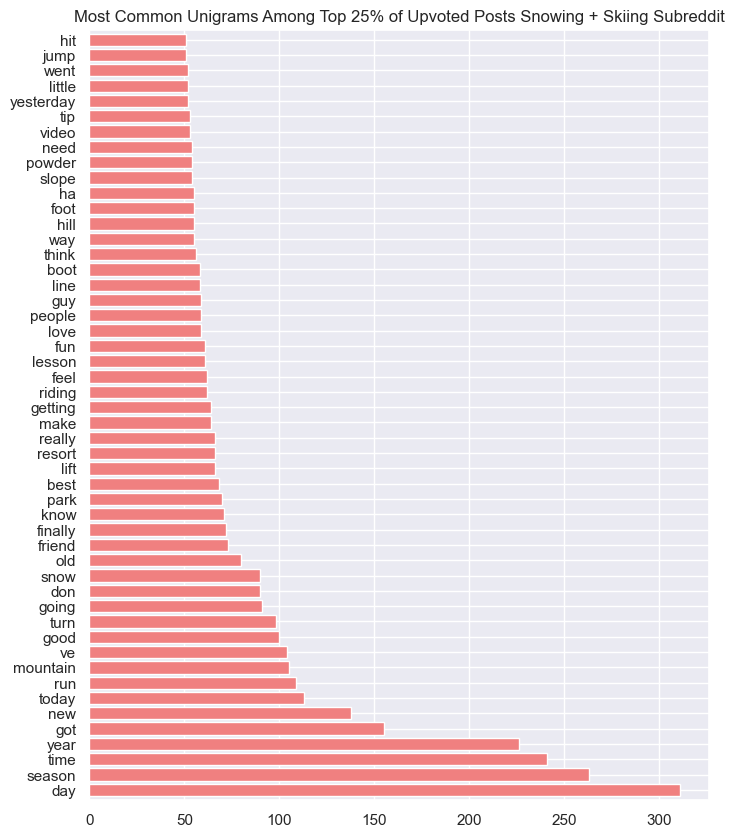

In [91]:
cvectorize(score_75, ['snowboard', 'snowboarding', 'board', 'ski', 'skier', 'skiing', 'skis', 'just', 'like', 'wa', 'http', 'https', 'www', 'reddit', 'subreddit'], (1,1), "Most Common Unigrams Among Top 25% of Upvoted Posts Snowing + Skiing Subreddit", "lightcoral");

### Most Common Words by Top 25% Most Commented Posts

In [92]:
# Get Top Words for Top 25% Most Commented Posts
snow_comm_75 = snow[snow.num_comments >= snow.num_comments.quantile(0.75)]
ski_comm_75 = ski[ski.num_comments >= snow.num_comments.quantile(0.75)]
# comm_75 = df[df.num_comments >= df.num_comments.quantile(0.75)]
comm_75 = pd.concat([snow_comm_75, ski_comm_75], axis=0)

C:\Users\farah\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le'] not in stop_words.
  warnings.warn(


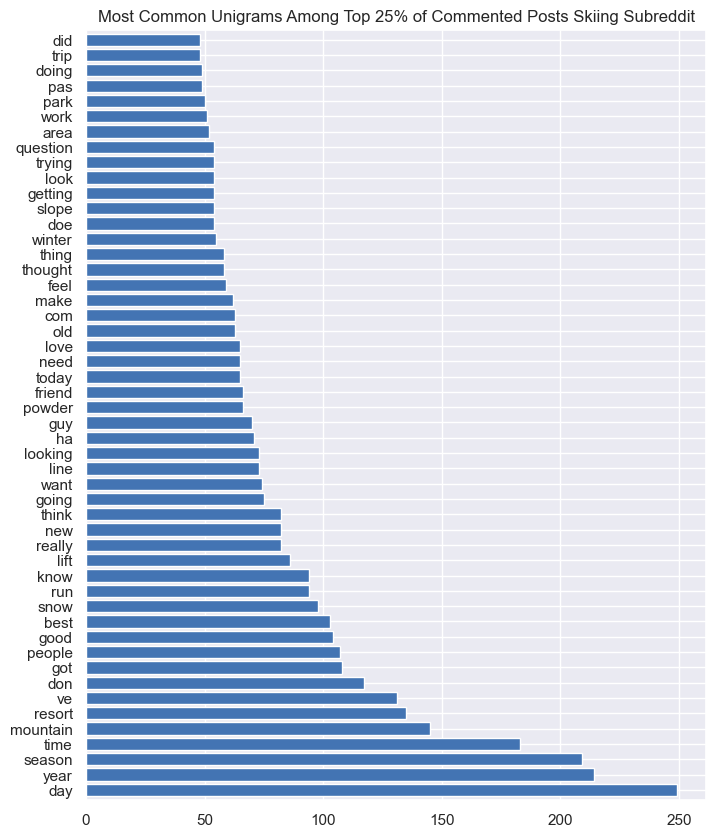

In [93]:
cvectorize(ski_comm_75, ['snowboard', 'snowboarding', 'board', 'ski', 'skier', 'skiing', 'skis', 'just', 'like', 'wa', 'http', 'https', 'www', 'reddit', 'subreddit'], (1,1), "Most Common Unigrams Among Top 25% of Commented Posts Skiing Subreddit", "#4374B3");

C:\Users\farah\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le'] not in stop_words.
  warnings.warn(


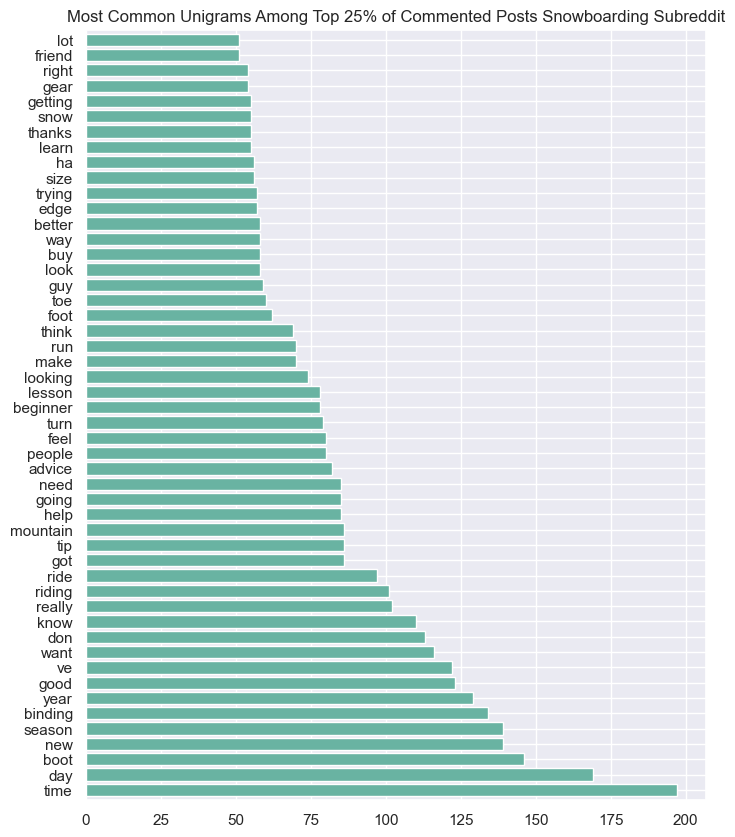

In [94]:
cvectorize(snow_comm_75, ['snowboard', 'snowboarding', 'board', 'ski', 'skier', 'skiing', 'skis', 'just', 'like', 'wa', 'http', 'https', 'www', 'reddit', 'subreddit'], (1,1), "Most Common Unigrams Among Top 25% of Commented Posts Snowboarding Subreddit", "#69b3a2");

C:\Users\farah\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le'] not in stop_words.
  warnings.warn(


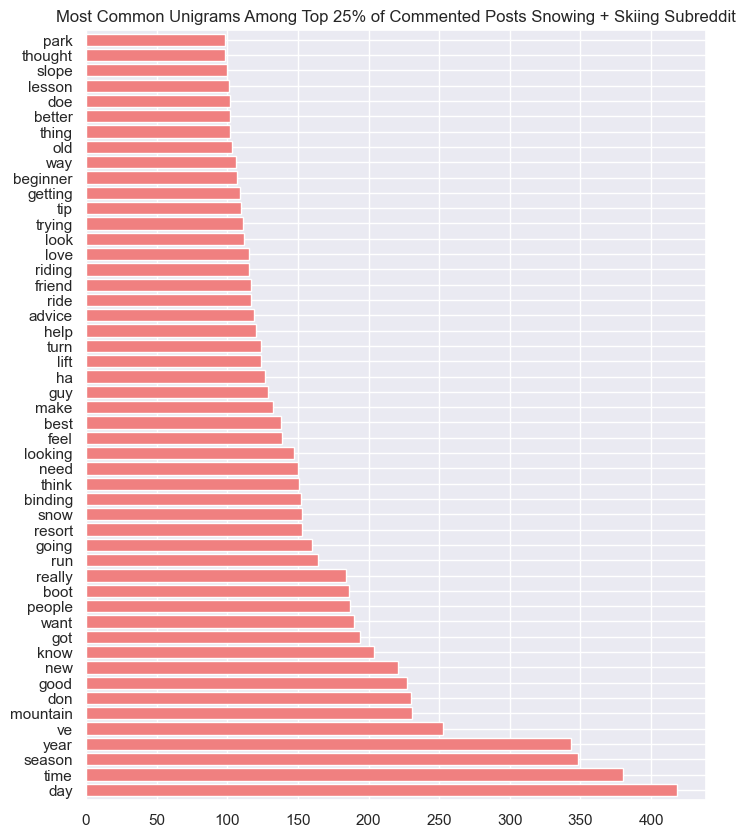

In [95]:
cvectorize(comm_75, ['snowboard', 'snowboarding', 'board', 'ski', 'skier', 'skiing', 'skis', 'just', 'like', 'wa', 'http', 'https', 'www', 'reddit', 'subreddit'], (1,1), "Most Common Unigrams Among Top 25% of Commented Posts Snowing + Skiing Subreddit", "lightcoral");

### Most Common Words Comparison

In [1]:
def cvectorize_2(df, stopwrd, gram):

    # Built-in English stopwords
    english_stopwords = CountVectorizer(stop_words='english').get_stop_words() # source: https://scikit-learn-ts-git-feature-docs-2-saasify.vercel.app/docs/classes/CountVectorizer
    custom_words = stopwrd

    # Combine English stopwords with the custom stopwords
    stopwords = list(english_stopwords) + custom_words

    cvec = CountVectorizer(stop_words=stopwords,
                           preprocessor=lemmatize_txt,
                           ngram_range=gram,
                          )
    X_vect = cvec.fit_transform(df['text'])
    X_vect.todense()
    X_vect_df = pd.DataFrame(data = X_vect.todense(), 
                             columns = cvec.get_feature_names_out())

    return X_vect_df;

X_vect_df = cvectorize_2(df, ['snowboard', 'snowboarding', 'board', 'ski', 'skier', 'skiing', 'skis', 'just', 'like', 'wa', 'http', 'https', 'www', 'reddit'], (1,1));


# Plot the top 30 words ressult by post_type
X_vect_df['subreddit'] = df['subreddit']
top30 = X_vect_df.sum().sort_values(ascending=False).head(30).index.tolist()

# set up bar plot variables
X = X_vect_df.sum().sort_values(ascending=False).head(30).index.tolist()
y_1 = X_vect_df[X_vect_df['subreddit'] == 'snowboardingnoobs'][top30].sum()
y_2 = X_vect_df[X_vect_df['subreddit'] == 'skiing'][top30].sum()

x_pos = [i for i, _ in enumerate(X)]


# Create a figure.
plt.figure(figsize=(25,12))

# Generate a multi bar plot:
sep = np.arange(len(X))
width = 0.40

plt.bar(sep, y_1, color = '#69b3a2', width = 0.4, label='Snowboarders')
plt.bar(sep + width, y_2, color = "#4374B3", width = 0.4, label='Skiiers')

plt.title('Top 30 Words Used in Snowboarding + Skiing Subreddit Communities', fontsize = 24)
plt.xlabel('Words', fontsize = 20)
plt.ylabel('Snowboarders vs. Skiiers', fontsize = 20)

plt.xticks(x_pos, X)
plt.xticks(sep + width / 2, X, rotation = 90, fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.legend(#bbox_to_anchor=(1.02, 0.95), loc='upper left', borderaxespad=0, 
           title = 'Subreddit Community', title_fontsize=16, fontsize=16 ); 

NameError: name 'df' is not defined

In [97]:
def cvectorize_2(df, stopwrd):

    # Built-in English stopwords
    english_stopwords = CountVectorizer(stop_words='english').get_stop_words() # source: https://scikit-learn-ts-git-feature-docs-2-saasify.vercel.app/docs/classes/CountVectorizer
    custom_words = stopwrd

    # Combine English stopwords with the custom stopwords
    stopwords = list(english_stopwords) + custom_words

    cvec = CountVectorizer(stop_words=stopwords)
    
    X_vect = cvec.fit_transform(df['text'])
    X_vect.todense()
    X_vect_df = pd.DataFrame(data = X_vect.todense(), 
                             columns = cvec.get_feature_names_out())

    return X_vect_df;

X_vect_df_25 = cvectorize_2(score_75, ['snowboard', 'snowboarding', 'board', 'ski', 'skier', 'skiing', 'skis', 'just', 'like', 'wa', 'http', 'https', 'www', 'reddit', 'subreddit']);

In [98]:
X_vect_df_25.shape

(2099, 5058)

In [99]:
# Merge in target variable
mrg_target = score_75[['subreddit']].reset_index(drop=True)
X_vect_df_25 = pd.concat([X_vect_df_25, mrg_target], axis=1)

In [100]:
agg = X_vect_df_25.groupby("subreddit").sum().reset_index()
agg

,subreddit,000,00s,04,05,06,10,100,1000,100s,...,zealand,zero,zillertal,zion,zone,zoo,zoom,zugspitze,zürs,åre
0,skiing,2,1,1,2,0,21,5,1,3,...,1,1,1,1,2,1,3,1,1,0
1,snowboardingnoobs,0,0,1,0,1,20,7,0,0,...,0,1,0,0,1,0,0,0,0,1


In [101]:
# Filter df to keep words with mentions in both skiing and snowboarding communities
filtered_agg = agg.loc[:, (agg.iloc[0] != 0) & (agg.iloc[1] != 0)].reset_index(drop=True)
filtered_agg

,subreddit,04,10,100,11,11th,12,12th,13,14,...,yeet,yes,yesterday,yo,york,young,younger,youtube,zero,zone
0,skiing,1,21,5,7,1,4,1,4,8,...,1,3,42,1,2,5,3,1,1,2
1,snowboardingnoobs,1,20,7,4,3,4,1,2,4,...,1,13,10,3,1,1,1,8,1,1


In [102]:
# Transpose, reset index for merge
filtered_agg2 = filtered_agg.transpose().reset_index()
filtered_agg2 = filtered_agg2[1:].rename(columns={'index': 'word', 0: 'Skiing', 1: 'Snowboarding'})
filtered_agg2.set_index('word')

,Skiing,Snowboarding
word,,
04,1,1
10,21,20
100,5,7
11,7,4
11th,1,3
...,...,...
young,5,1
younger,3,1
youtube,1,8


In [103]:
# Get Top 50 highest total mentions of words
total_mentions = agg.iloc[0] + agg.iloc[1]

word_counts_df = pd.DataFrame({'word': total_mentions.index, 'count': total_mentions.values})
word_counts_df = word_counts_df[1:]
word_counts_df = word_counts_df.sort_values(by = "count", ascending=False)[:50].reset_index().drop(columns='index').set_index('word')
word_counts_df

,count
word,
season,249
day,245
time,215
got,155
new,138
year,126
today,113
ve,104
years,100


In [104]:
# Merge Ski and Snowboard mentions to Top 50 Words
filtered_agg3 = pd.merge(left=word_counts_df, right=filtered_agg2, how='left', on='word')
filtered_agg3

,word,count,Skiing,Snowboarding
0,season,249,131,118
1,day,245,128,117
2,time,215,93,122
3,got,155,83,72
4,new,138,41,97
5,year,126,63,63
6,today,113,64,49
7,ve,104,59,45
8,years,100,46,54
9,good,98,45,53


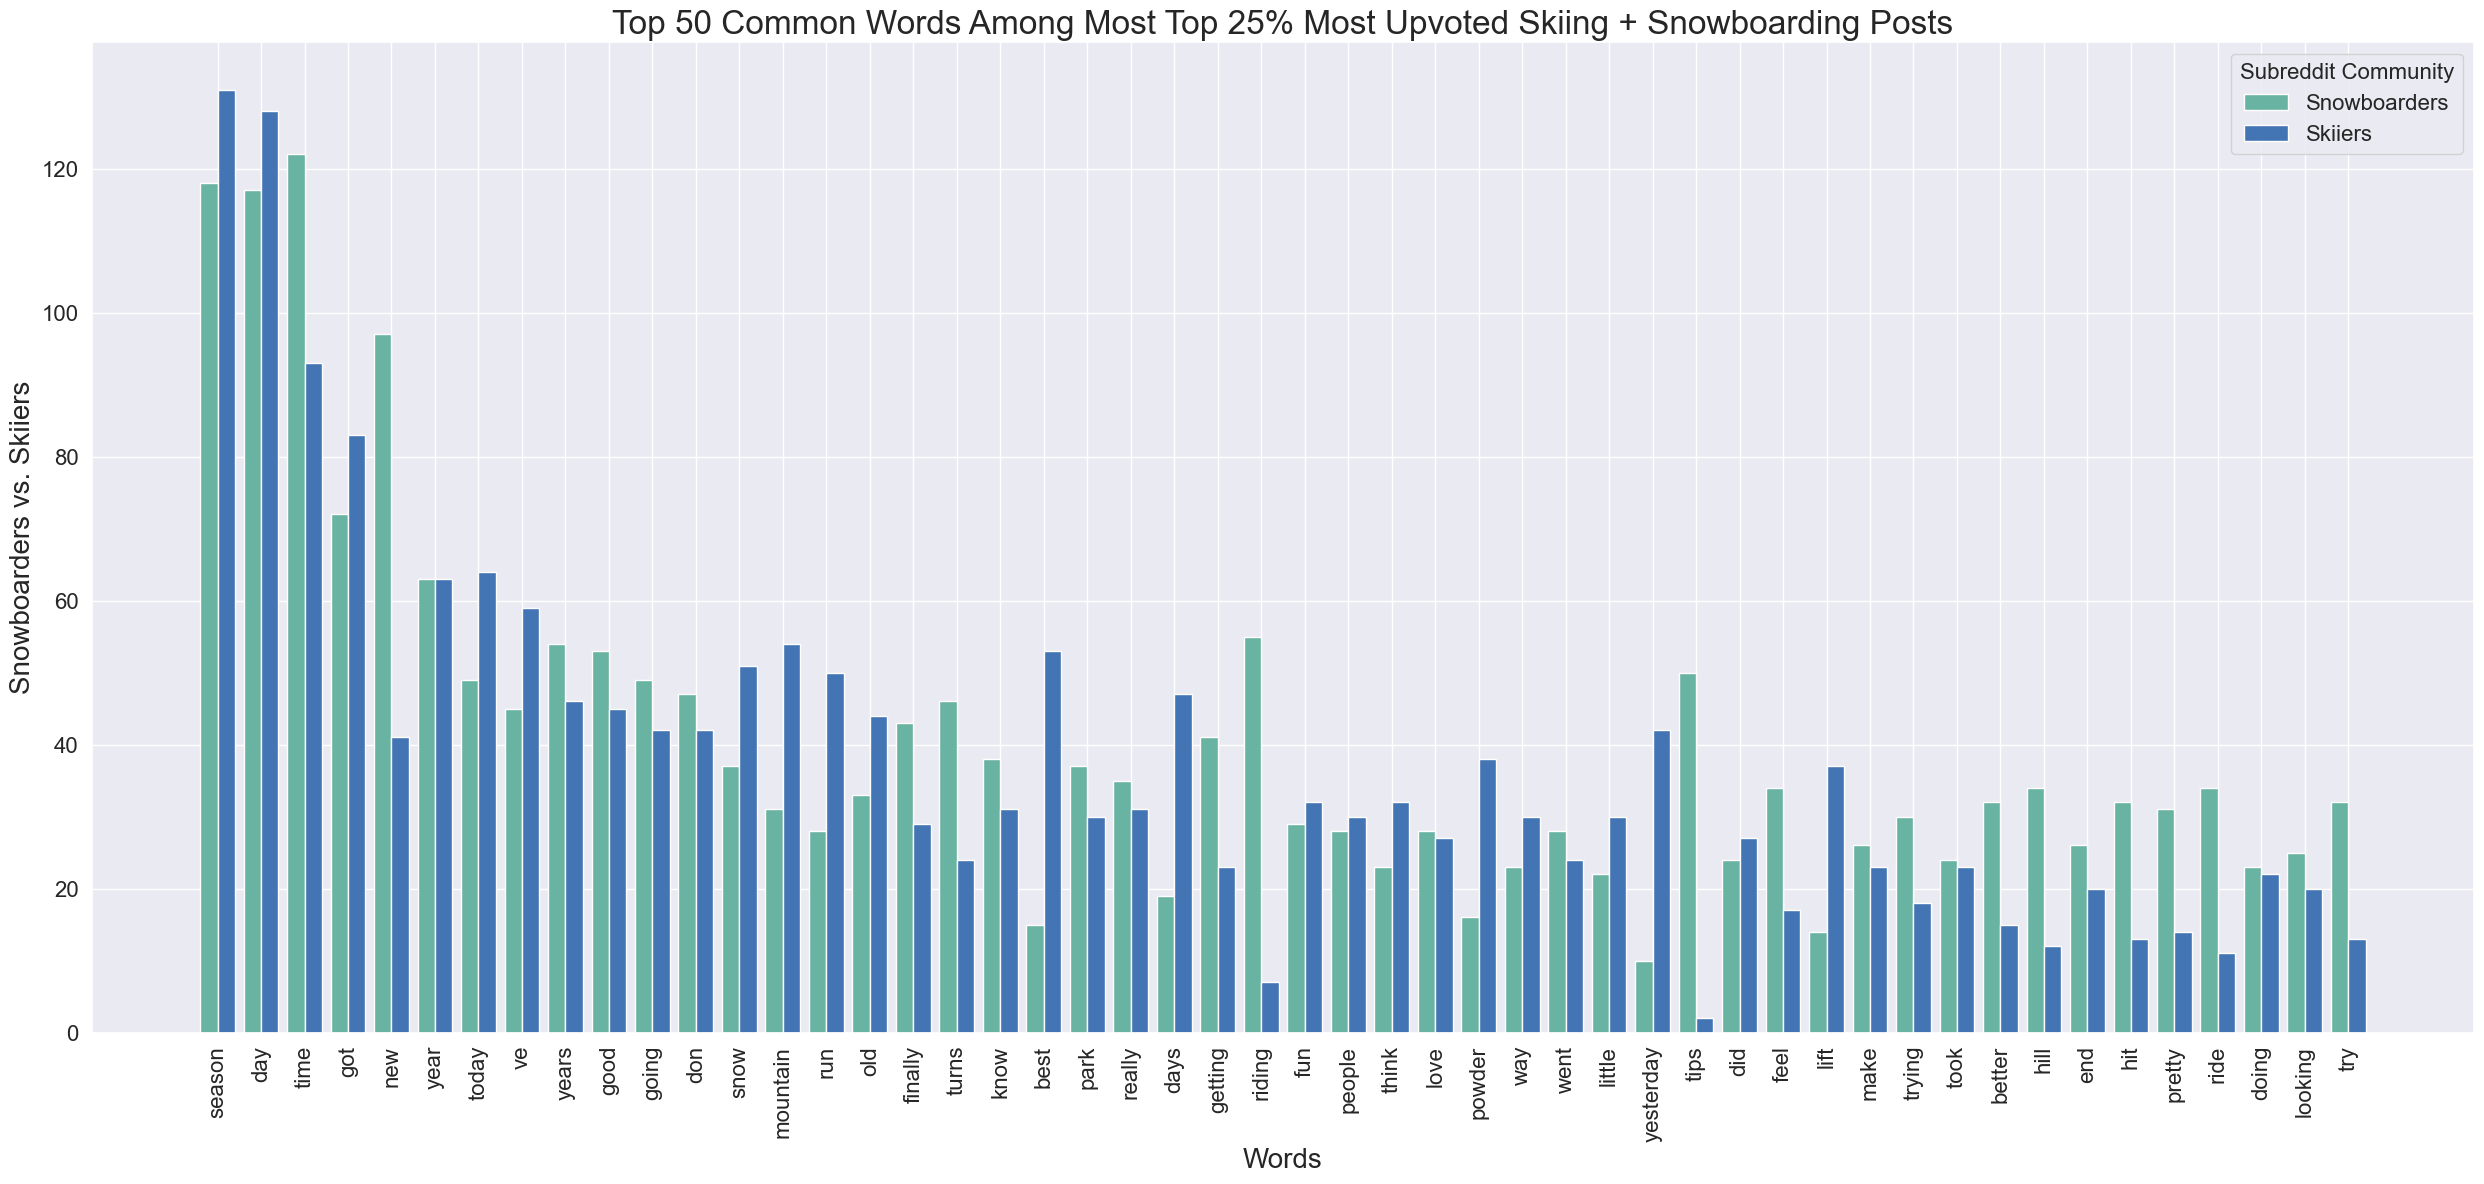

In [105]:
# Adapted from Python Graphic Library and https://stackoverflow.com/questions/52028043/side-by-side-barplot and
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
data = filtered_agg3[['word', 'Skiing', 'Snowboarding']]

# Set the x-axis values as word column
x = data['word']

# Set the y values to be counts for Skiing and Snowboarding mentions
ski_mentions = data['Skiing']
snowboard_mentions = data['Snowboarding']


# Create a figure
plt.figure(figsize=(25,12))

sep = np.arange(len(x))
bar_width = 0.40

plt.bar(sep, snowboard_mentions, color = '#69b3a2', width = bar_width, label='Snowboarders')
plt.bar(sep + bar_width, ski_mentions, color = "#4374B3", width = bar_width, label='Skiiers')

plt.title('Top 50 Common Words Among Top 25% Most Upvoted Skiing + Snowboarding Posts', fontsize = 24)
plt.xlabel('Words', fontsize = 20)
plt.ylabel('Snowboarders vs. Skiiers', fontsize = 20)


plt.xticks(sep + bar_width / 2, x, rotation = 90, fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.legend(#bbox_to_anchor=(1.02, 0.95), loc='upper left', borderaxespad=0, 
           title = 'Subreddit Community', title_fontsize=16, fontsize=16 );

##### <span style = 'color: blue'> Snowboarders and skiers both engaged on Reddit to discuss the best time/day/year/place to pursue their respective activities. This is indicated by top shared words which include season, day, time, year, mountain, park, best, powder). </span>